In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (4,3)
mpl.rcParams['figure.dpi'] = 100

lmax = 100

from getdist.gaussian_mixtures import GaussianND
from getdist import plots

2.039917004449462e-09


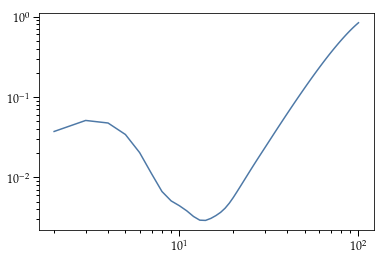

In [2]:
from classy import Class

planck_noise = 120 # uK_arcmin
class_noise = 30 # uK_arcmin
cv_noise = 0

# Define your cosmology (what is not specified will be set to CLASS default parameters)
params = {
    'output': 'tCl pCl lCl',
    'l_max_scalars': lmax,
    'lensing': 'yes',
    'A_s': 2.3e-9,
    'n_s': 0.965,
    'tau_reio':0.06}

amp = params['A_s']*np.exp(-2*params['tau_reio'])
print(amp)
cosmo = Class()
cosmo.set(params)
cosmo.compute()
cls = cosmo.lensed_cl(lmax)
cosmo.struct_cleanup()
#cosmo.empty()
Z = cls['ell']*(cls['ell']+1)/(2*np.pi)*(cosmo.T_cmb()*1e6)**2
plt.loglog(cls['ell'][2:], cls['ee'][2:]*Z[2:])

In [3]:
from scipy.integrate import trapz, cumtrapz
def get_tau(thermo, zmax=100, xmin=2e-4):
    eta = thermo['conf. time [Mpc]']
    z = thermo['z']
    x_e = thermo['x_e']
    dtaudeta = thermo["kappa' [Mpc^-1]"]
    sigmaTan_p = dtaudeta/x_e
    integrand = -sigmaTan_p*x_e
    return trapz(integrand[(x_e>xmin) & (z<zmax)], x=eta[(x_e>xmin) & (z<zmax)])

def get_tau_z(thermo, zmax=100, xmin=2e-4):
    eta = thermo['conf. time [Mpc]']
    z = thermo['z']
    x_e = thermo['x_e']
    dtaudeta = thermo["kappa' [Mpc^-1]"]
    sigmaTan_p = dtaudeta/x_e
    integrand = -sigmaTan_p*x_e
    return z, cumtrapz(integrand, x=eta)


def get_twotau(thermo, zmax=100, xmin=2e-4):
    eta = thermo['conf. time [Mpc]']
    z = thermo['z']
    x_e = thermo['x_e']
    dtaudeta = thermo["kappa' [Mpc^-1]"]
    sigmaTan_p = dtaudeta/x_e
    integrand = -sigmaTan_p*x_e
    zre = z[np.where(x_e < 0.5)[0][0]]
    zsplit = 1+zre
    tau_lo = trapz(integrand[(x_e>xmin) & (z<zsplit)], x=eta[(x_e>xmin) & (z<zsplit)])
    tau_hi = trapz(integrand[(x_e>xmin) & (z>zsplit) & (z<zmax)], x=eta[(x_e>xmin) & (z>zsplit) & (z<zmax)])
    return zsplit, tau_lo, tau_hi


In [4]:
def twinplot(ell, Cl, axes=None, label=None, color='k', marker='.',
        linestyle=' ', ymin=None, ymax=None, alpha=1, lw=None, spec='EE',
            xlabels=True, ylabels_l=True, ylabels_r=True):
    if axes == None:
        ax = plt.gca()
        axes = [ax, ax.twinx()]

    axes[0].semilogx(ell, np.log10(Cl), label=label, color=color, marker=marker,
            linestyle=linestyle, alpha=alpha, lw=lw)

    if (ymin == None) & (ymax == None):
        ymin, ymax = axes[0].get_ylim()
    else:
        ymin, ymax = np.log10(ymin), np.log10(ymax)
        axes[0].set_ylim(ymin, ymax)
    xmin, xmax = axes[0].get_xlim()
    values = np.arange(int(ymin), int(ymax)+1)
    labels = 10.**values
    axes[0].set_yticks(values, minor=False)

    # If you do this, you get tick labels like $10^{-16}$.
    f = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=True)
    g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % 10.**x))
    axes[0].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(g))
    # If you do this, you get tick labels like 1e-16
    #axes[0].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

    xticks = np.array([2, 5, 10, 20, 50, 100, 200])
    axes[0].set_xticks(xticks)
    axes[0].set_xticklabels(xticks)


    l0 = np.array([], dtype='float')
    labels = np.arange(1, 10)
    for i in range(values[0]-1, values[-1]+2):
        l0 = np.concatenate((l0, 10**i*labels))
    axes[0].set_yticks(np.log10(l0), minor=True)
    axes[0].set_ylim(ymin, ymax)

    base = np.array([3, 5, 10, 15])
    labels = np.array([300, 500, 1000, 1500, 3000, 5000,
        10000, 15000, 30000, 50000, int(1e5), int(1.5e5), int(3e5), int(5e5)]).astype('str')
    labels = np.concatenate(((10*base).astype('str'), labels))
    labels = np.concatenate((base.astype('str'), labels))
    labels = np.concatenate((np.round((10**-1*base),2).astype('str'), labels))
    labels = np.concatenate(((np.round(10**-2*base,2)).astype('str'), labels))

    # Convert from uKarcmin to uK^2 sr
    values = np.log10((np.pi*labels.astype('float')/180/60)**2)
    axes[1].set_yticks(values, minor=False)
    axes[1].get_yaxis().set_major_formatter(mpl.ticker.FixedFormatter(labels))


    l0 = np.array([], dtype='float')
    labels = np.arange(1, 10, 0.5)
    for i in range(-2, 6):
        l0 = np.concatenate((l0, 10**i*labels))
    axes[1].set_yticks(np.log10((np.pi*l0/180/60)**2), minor=True)
    axes[1].set_ylim(axes[0].get_ylim())

    if ylabels_l:
        spec = r'\mathrm{{ {0} }}'.format(spec)
        axes[0].set_ylabel(r'$C_\ell^' + spec + r'$ [$\mathrm{\mu K^2\,sr}$]')
    if ylabels_r:
        axes[1].set_ylabel(r'$w_p^{-1/2}$ [$\mathrm{\mu K\ arcmin}$]')

    if xlabels:
        axes[0].set_xlabel(r'$\ell$')
        axes[0].set_xlim(xmin, 95)


    return axes


In [5]:
def get_spectra(zreio, x_e, dz=0.5, history=False, spectra=False, both=False, 
                all_spectra=False, lmax=100, therm=False, zstartmax=50):
    cosmo.struct_cleanup()
    cosmo.empty()
    params['many_tanh_z'] = '3.5,' + str(zreio) +',28'
    params['many_tanh_xe'] = '-2,-1,'+str(max(x_e, 2e-4))
    params['many_tanh_width'] = dz
    params['reionization_z_start_max'] = zstartmax

    params['hyper_flat_approximation_nu'] = 7000. # The higher this is, the more exact
    params['transfer_neglect_delta_k_S_t0'] = 0.0017 # The lower these are, the more exact
    params['transfer_neglect_delta_k_S_t1'] = 0.0005
    params['transfer_neglect_delta_k_S_t2'] = 0.0017
    params['transfer_neglect_delta_k_S_e'] = 0.0013
    params['delta_l_max'] = 1000 # difference between l_max in unlensed and lensed spectra

    cosmo.set(params)
    cosmo.compute()
    thermo = cosmo.get_thermodynamics()
    tau = get_tau(thermo)
    params['A_s'] = 2.3e-9*np.exp(-2*0.06)/np.exp(-2*tau)
    cosmo.set(params)
    cosmo.compute()
    if both:
        thermo = cosmo.get_thermodynamics()
        z, xe = thermo['z'], thermo['x_e']
        cls = cosmo.lensed_cl(lmax)
        ell, EE, TE = cls['ell'], cls['ee'], cls['te']
        if all_spectra:
            return z, xe, ell, EE, TE, cls['tt']
        else:
            return z, xe, ell, EE, TE

    elif therm:
        therm = cosmo.get_thermodynamics()
        return therm
    elif spectra:
        cls = cosmo.lensed_cl(lmax)
        ell, TT, EE, TE = cls['ell'], cls['tt'], cls['ee'], cls['te']
        if all_spectra:
            return ell, EE, TE, TT
        else:
            return ell, EE, TE

    elif history:
        thermo = cosmo.get_thermodynamics()
        z, xe = thermo['z'], thermo['x_e']
        return z, xe
    else:
        return

0.06261794368708372 (6.598827154017061, 0.0347849631196545, 0.027767267715849104)
2.039917004449462e-09


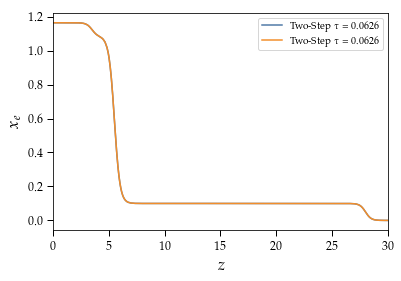

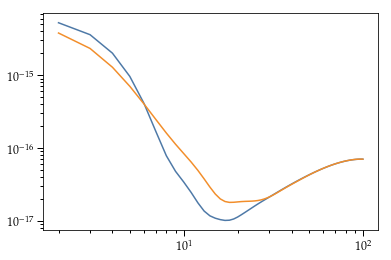

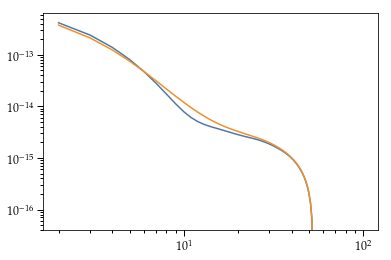

In [6]:
params['reio_parametrization'] ='reio_many_tanh'

params['many_tanh_num'] = 3
params['many_tanh_z'] = '3.5,5.5,28'
params['many_tanh_xe'] = '-2,-1,0.1'
#params['many_tanh_num'] = 2
#params['many_tanh_z'] = '3.5,11.3'
#params['many_tanh_xe'] = '-2,-1'

params['many_tanh_width'] = 0.5
pars = ['tau_reio', 'binned_reio_num', 'binned_reio_z', 'binned_reio_xe', 'binned_reio_step_sharpness']
for p in pars:
    if p in params: del params[p]

cosmo.empty()
cosmo.set(params)
cosmo.compute()
thermo = cosmo.get_thermodynamics()
#plt.plot(thermo['z'], thermo['x_e'])
#plt.xlim([0,30])
plt.xlabel(r'$z$')
plt.ylabel(r'$x_e$')
print(get_tau(thermo), get_twotau(thermo))
zsplit2, taulo, tauhi = get_twotau(thermo)
amp = params['A_s']*np.exp(-2*0.06)
params['A_s'] = amp/np.exp(-2*(taulo+tauhi))
cosmo.set(params)
cosmo.compute()
thermo = cosmo.get_thermodynamics()
plt.plot(thermo['z'], thermo['x_e'], label=r'Two-Step $\tau={0}$'.format(np.round(taulo+tauhi,4)))
plt.xlim([0,30])
print(amp)
plt.legend(loc='best')


plt.plot(thermo['z'], thermo['x_e'], label=r'Two-Step $\tau={0}$'.format(np.round(taulo+tauhi,4)))
plt.xlim([0,30])
plt.legend(loc='best')
#plt.yscale('log')

plt.figure()
cls2 = cosmo.lensed_cl(lmax)
Z = cls2['ell']*(cls2['ell']+1)/(2*np.pi)*(cosmo.T_cmb()*1e6)**2
plt.loglog(cls['ell'][2:], cls['ee'][2:])   
plt.loglog(cls2['ell'][2:], cls2['ee'][2:])

plt.figure()
plt.loglog(cls['ell'][2:], cls['te'][2:])
plt.loglog(cls2['ell'][2:], cls2['te'][2:])

cosmo.struct_cleanup()

/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


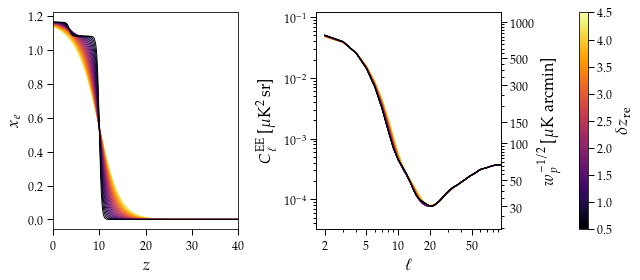

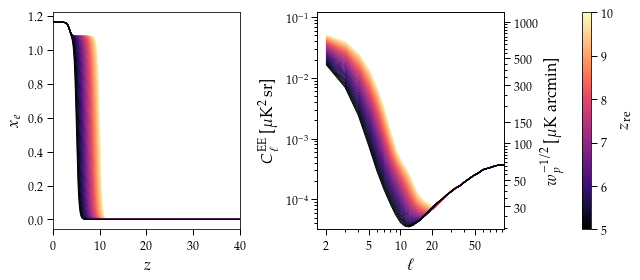

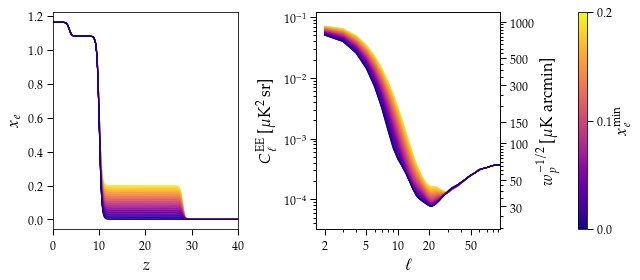

In [7]:
zs = np.linspace(5, 10, 50)
xes = np.linspace(0, 0.2, 50)
z0 = 10
xe0 = 0

lw = 1
ymin = 3.2e-5
ymax = 1.2e-1
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9,4), gridspec_kw={"width_ratios":[1,1, 0.05]})
ax1 = axes[0]
ax2 = axes[1]
cax = axes[2]
axs2 = [ax2, ax2.twinx()]
dzs = np.linspace(0.5, 4.5, len(xes)//2)
for i in range(len(dzs))[::-1]:
    z, xe, ell, EE, TE = get_spectra(z0, xe0, dz=dzs[i], both=True, zstartmax=100)

    ax1.plot(z, xe, color=plt.cm.inferno(i/len(dzs)),lw=lw)
    ax1.set_xlim([0, 40])
    ax1.set_xlabel(r'$z$')
    ax1.set_ylabel(r'$x_e$')
    twinplot(ell, (2.7e6)**2*EE, lw=lw, linestyle='-', marker=None, color=plt.cm.inferno(i/len(dzs)), axes=axs2, ymin=ymin, ymax=ymax)
plt.xlim(right=95)
sm = plt.cm.ScalarMappable(cmap=plt.cm.inferno, norm=plt.Normalize(vmin=dzs.min(), vmax=dzs.max()))
sm._A = []
fig.colorbar(sm, cax=cax, label=r'$\delta z_\mathrm{re}$')

plt.tight_layout()


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9,4), gridspec_kw={"width_ratios":[1,1, 0.05]})
ax1 = axes[0]
ax2 = axes[1]
cax = axes[2]
axs2 = [ax2, ax2.twinx()]
taulos1 = []
tauhis1 = []
for i in range(len(zs))[::-1]:
    z, xe, ell, EE, TE = get_spectra(zs[i], xe0, both=True)
    thermo = get_spectra(zs[i], xe0, therm=True)
    _, taulo, tauhi = get_twotau(thermo, zmax=100, xmin=2e-4)
    taulos1.append(taulo)
    tauhis1.append(tauhi)
    ax1.plot(z, xe, color=plt.cm.magma(i/len(zs)), lw=lw)
    ax1.set_xlim([0, 40])
    ax1.set_xlabel(r'$z$')
    ax1.set_ylabel(r'$x_e$')
    twinplot(ell, (2.7e6)**2*EE, linestyle='-', marker=None, color=plt.cm.magma(i/len(zs)), axes=axs2, lw=lw, ymin=ymin, ymax=ymax)
plt.xlim(right=95)
sm = plt.cm.ScalarMappable(cmap=plt.cm.magma, norm=plt.Normalize(vmin=zs.min(), vmax=zs.max()))
sm._A = []
fig.colorbar(sm, cax=cax, label=r'$z_\mathrm{re}$')
taulos1 = taulos1[::-1]
tauhis1 = tauhis1[::-1]

plt.tight_layout()


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9,4), gridspec_kw={"width_ratios":[1,1, 0.05]})
ax1 = axes[0]
ax2 = axes[1]
cax = axes[2]
axs2 = [ax2, ax2.twinx()]
taulos2 = []
tauhis2 = []
for i in range(len(zs))[::-1]:
    z, xe, ell, EE, TE = get_spectra(z0, xes[i], both=True)
    thermo = get_spectra(z0, xes[i], therm=True)
    _, taulo, tauhi = get_twotau(thermo, zmax=100, xmin=2e-4)
    taulos2.append(taulo)
    tauhis2.append(tauhi)

    ax1.plot(z, xe, color=plt.cm.plasma(i/len(zs)),lw=lw)
    ax1.set_xlim([0, 40])
    ax1.set_xlabel(r'$z$')
    ax1.set_ylabel(r'$x_e$')
    twinplot(ell, (2.7e6)**2*EE, lw=lw, linestyle='-', marker=None, color=plt.cm.plasma(i/len(zs)), axes=axs2, ymin=ymin, ymax=ymax)
plt.xlim(right=95)
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=xes.min(), vmax=xes.max()))
sm._A = []
fig.colorbar(sm, cax=cax, label=r'$x_e^\mathrm{min}$', ticks=[0, 0.1, 0.2])

plt.tight_layout()

/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log10


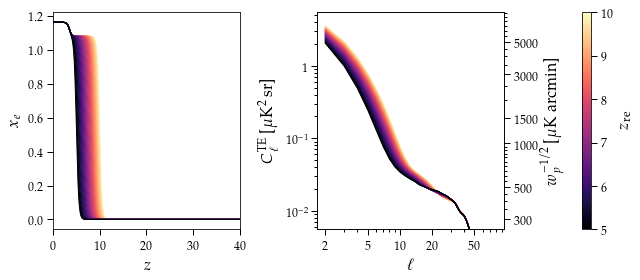

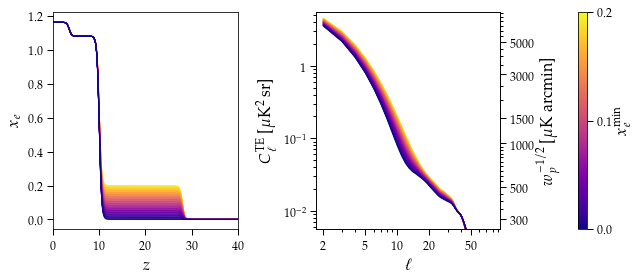

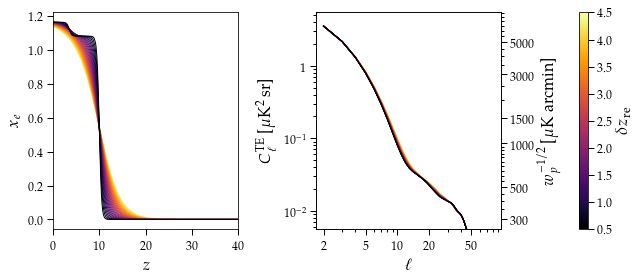

In [8]:
zs = np.linspace(5, 10, 50)
xes = np.linspace(0, 0.2, 50)
z0 = 10
xe0 = 0

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9,4), gridspec_kw={"width_ratios":[1,1, 0.05]})
ax1 = axes[0]
ax2 = axes[1]
cax = axes[2]
axs2 = [ax2, ax2.twinx()]
for i in range(len(zs))[::-1]:
    z, xe, ell, EE, TE = get_spectra(zs[i], xe0, both=True)
    thermo = get_spectra(zs[i], xe0, therm=True)
    ax1.plot(z, xe, color=plt.cm.magma(i/len(zs)), lw=lw)
    ax1.set_xlim([0, 40])
    ax1.set_xlabel(r'$z$')
    ax1.set_ylabel(r'$x_e$')
    twinplot(ell, (2.7e6)**2*TE, linestyle='-', marker=None, color=plt.cm.magma(i/len(zs)), 
             axes=axs2, spec='TE', lw=lw, ymin=5.5e-3, ymax=5.5)
plt.xlim(right=95)
sm = plt.cm.ScalarMappable(cmap=plt.cm.magma, norm=plt.Normalize(vmin=zs.min(), vmax=zs.max()))
sm._A = []
fig.colorbar(sm, cax=cax, label=r'$z_\mathrm{re}$')


plt.tight_layout()
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9,4), gridspec_kw={"width_ratios":[1,1, 0.05]})
ax1 = axes[0]
ax2 = axes[1]
cax = axes[2]
axs2 = [ax2, ax2.twinx()]
for i in range(len(zs))[::-1]:
    z, xe, ell, EE, TE = get_spectra(z0, xes[i], both=True)
    thermo = get_spectra(z0, xes[i], therm=True)
    _, taulo, tauhi = get_twotau(thermo, zmax=100, xmin=2e-4)

    ax1.plot(z, xe, color=plt.cm.plasma(i/len(zs)), lw=lw)
    ax1.set_xlim([0, 40])
    ax1.set_xlabel(r'$z$')
    ax1.set_ylabel(r'$x_e$')
    twinplot(ell, (2.7e6)**2*TE, linestyle='-', marker=None, color=plt.cm.plasma(i/len(zs)), 
             axes=axs2, spec='TE', lw=lw, ymin=5.5e-3, ymax=5.5)
plt.xlim(right=95)
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=xes.min(), vmax=xes.max()))
sm._A = []
fig.colorbar(sm, cax=cax, label=r'$x_e^\mathrm{min}$', ticks=[0, 0.1, 0.2])

plt.tight_layout()



fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9,4), gridspec_kw={"width_ratios":[1,1, 0.05]})
ax1 = axes[0]
ax2 = axes[1]
cax = axes[2]
axs2 = [ax2, ax2.twinx()]
dzs = np.linspace(0.5, 4.5, len(xes)//2)
for i in range(len(dzs))[::-1]:
    z, xe, ell, EE, TE = get_spectra(z0, xe0, dz=dzs[i], both=True, zstartmax=100)
    thermo = get_spectra(z0, xes[i], therm=True)
    _, taulo, tauhi = get_twotau(thermo, zmax=100, xmin=2e-4)

    ax1.plot(z, xe, color=plt.cm.inferno(i/len(dzs)),lw=lw)
    ax1.set_xlim([0, 40])
    ax1.set_xlabel(r'$z$')
    ax1.set_ylabel(r'$x_e$')
    twinplot(ell, (2.7e6)**2*TE, linestyle='-', marker=None, color=plt.cm.inferno(i/len(dzs)), 
             axes=axs2, spec='TE', lw=lw, ymin=5.5e-3, ymax=5.5)
plt.xlim(right=95)
sm = plt.cm.ScalarMappable(cmap=plt.cm.inferno, norm=plt.Normalize(vmin=dzs.min(), vmax=dzs.max()))
sm._A = []
fig.colorbar(sm, cax=cax, label=r'$\delta z_\mathrm{re}$')

plt.tight_layout()

/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log10
/etc/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log10


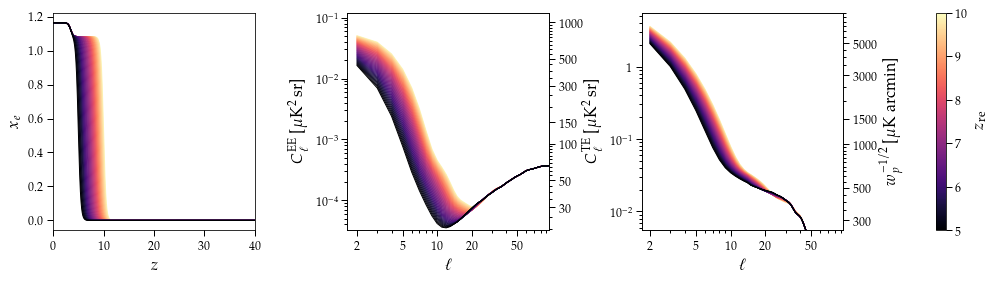

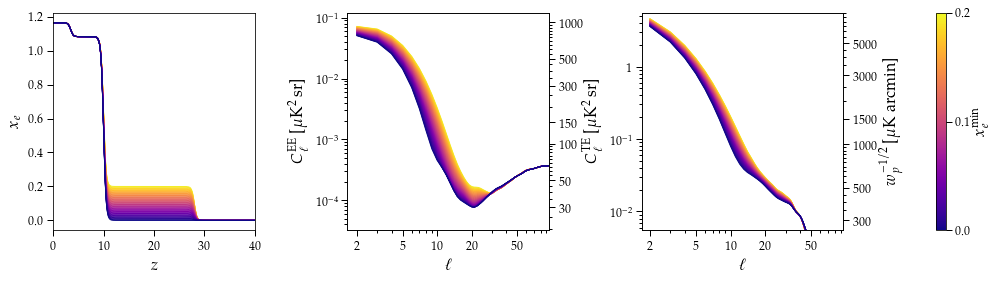

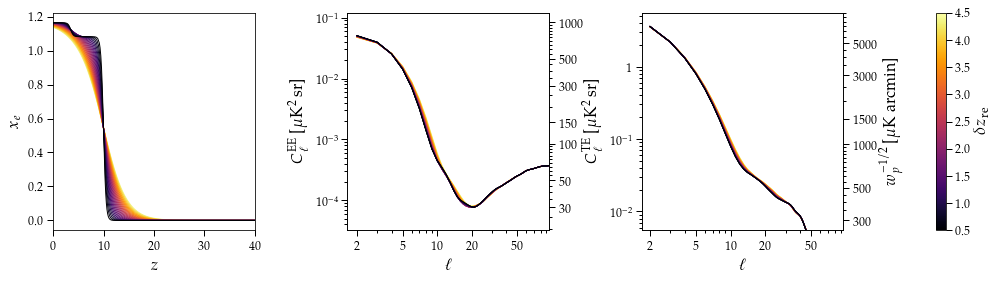

In [9]:
lw = 1
ymin = 3.2e-5
ymax = 1.2e-1
num = 50


zs = np.linspace(5, 10, num)
xes = np.linspace(0, 0.2, num)
z0 = 10
xe0 = 0

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4), 
                         gridspec_kw={"width_ratios":[1,1,1,0.05], "wspace":0.6})
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]
cax = axes[3]
axs2 = [ax2, ax2.twinx()]
axs3 = [ax3, ax3.twinx()]
for i in range(len(zs))[::-1]:
    z, xe, ell, EE, TE = get_spectra(zs[i], xe0, both=True)
    thermo = get_spectra(zs[i], xe0, therm=True)
    ax1.plot(z, xe, color=plt.cm.magma(i/len(zs)), lw=lw)
    ax1.set_xlim([0, 40])
    ax1.set_xlabel(r'$z$')
    ax1.set_ylabel(r'$x_e$')
    twinplot(ell, (2.7e6)**2*EE, linestyle='-', marker=None, color=plt.cm.magma(i/len(zs)), 
             axes=axs2, spec='EE', lw=lw, ymin=ymin, ymax=ymax, ylabels_r=False)
    twinplot(ell, (2.7e6)**2*TE, linestyle='-', marker=None, color=plt.cm.magma(i/len(zs)), 
             axes=axs3, spec='TE', lw=lw, ymin=5.5e-3, ymax=5.5)
sm = plt.cm.ScalarMappable(cmap=plt.cm.magma, norm=plt.Normalize(vmin=zs.min(), vmax=zs.max()))
sm._A = []
fig.colorbar(sm, cax=cax, label=r'$z_\mathrm{re}$')

plt.savefig('zre_var.pdf', bbox_inches='tight')

plt.tight_layout()
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4), 
                         gridspec_kw={"width_ratios":[1,1,1,0.05], "wspace":0.6})
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]
cax = axes[3]
axs2 = [ax2, ax2.twinx()]
axs3 = [ax3, ax3.twinx()]
for i in range(len(zs))[::-1]:
    z, xe, ell, EE, TE = get_spectra(z0, xes[i], both=True)
    thermo = get_spectra(z0, xes[i], therm=True)
    _, taulo, tauhi = get_twotau(thermo, zmax=100, xmin=2e-4)

    ax1.plot(z, xe, color=plt.cm.plasma(i/len(zs)), lw=lw)
    ax1.set_xlim([0, 40])
    ax1.set_xlabel(r'$z$')
    ax1.set_ylabel(r'$x_e$')
    twinplot(ell, (2.7e6)**2*EE, linestyle='-', marker=None, color=plt.cm.plasma(i/len(zs)), 
             axes=axs2, spec='EE', lw=lw, ymin=ymin, ymax=ymax, ylabels_r=False)
    twinplot(ell, (2.7e6)**2*TE, linestyle='-', marker=None, color=plt.cm.plasma(i/len(zs)), 
             axes=axs3, spec='TE', lw=lw, ymin=5.5e-3, ymax=5.5)
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=xes.min(), vmax=xes.max()))
sm._A = []
fig.colorbar(sm, cax=cax, label=r'$x_e^\mathrm{min}$', ticks=[0, 0.1, 0.2])

plt.tight_layout()
plt.savefig('xmin_var.pdf', bbox_inches='tight')


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4), 
                         gridspec_kw={"width_ratios":[1,1,1,0.05], "wspace":0.6})
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]
cax = axes[3]
axs2 = [ax2, ax2.twinx()]
axs3 = [ax3, ax3.twinx()]
dzs = np.linspace(0.5, 4.5, len(xes)//2)
for i in range(len(dzs))[::-1]:
    z, xe, ell, EE, TE = get_spectra(z0, xe0, dz=dzs[i], both=True, zstartmax=100)
    thermo = get_spectra(z0, xes[i], therm=True)
    _, taulo, tauhi = get_twotau(thermo, zmax=100, xmin=2e-4)

    ax1.plot(z, xe, color=plt.cm.inferno(i/len(dzs)),lw=lw)
    ax1.set_xlim([0, 40])
    ax1.set_xlabel(r'$z$')
    ax1.set_ylabel(r'$x_e$')
    twinplot(ell, (2.7e6)**2*EE, linestyle='-', marker=None, color=plt.cm.inferno(i/len(dzs)), 
             axes=axs2, spec='EE', lw=lw, ymin=ymin, ymax=ymax, ylabels_r=False, ylabels_l=True)
    twinplot(ell, (2.7e6)**2*TE, linestyle='-', marker=None, color=plt.cm.inferno(i/len(dzs)), 
             axes=axs3, spec='TE', lw=lw, ymin=5.5e-3, ymax=5.5, ylabels_l=True)
sm = plt.cm.ScalarMappable(cmap=plt.cm.inferno, norm=plt.Normalize(vmin=dzs.min(), vmax=dzs.max()))
sm._A = []
fig.colorbar(sm, cax=cax, label=r'$\delta z_\mathrm{re}$')
plt.savefig('dz_var.pdf', bbox_inches='tight')
#plt.tight_layout()

0.009540779954977745 -0.019081793779328518
-0.2285245474403003 0.046289822594106474
0.05191064513984556


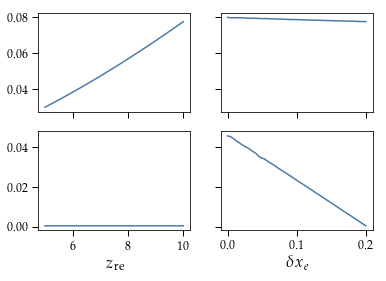

In [10]:
# taulos1, tauhis1 is where zre changes and xe stays the same.
from scipy import stats
tauhis1 = np.array(tauhis1)
taulos2 = np.array(taulos2)
# taulos2, tauhis2 is where xe changes and zre stays the same.
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row')
ax[0,0].plot(zs, taulos1)
#plt.title(r'$\tau_\mathrm{lo-z}$')
#plt.subplot(222)
ax[1,0].plot(zs, tauhis1)
ax[1,0].set_xlabel(r'$z_\mathrm{re}$')
# this should have practically no effect
#plt.title(r'$\tau_\mathrm{hi-z}$')
#plt.subplot(223)
ax[0,1].plot(xes, taulos2)
# this should have practically no effect
#plt.subplot(224)
ax[1,1].plot(xes, tauhis2)
ax[1,1].set_xlabel(r'$\delta x_e$')

slope, intercept, r_value, p_value, std_err = stats.linregress(zs, taulos1)
print(slope, intercept)

slope, intercept, r_value, p_value, std_err = stats.linregress(xes, tauhis2)
print(slope, intercept)


def get_taus_simp(zre, xe):
    taulo = -0.01736288370260474 + 0.00929724716106184*zre
    tauhi = 0.000491488782223699 + 0.259971141877111*xe
    return taulo, tauhi, taulo+tauhi

dtaulodz = 0.00929724716106184
dtauhidx = 0.259971141877111

print(get_taus_simp(6, 0.05)[2])

In [11]:
def get_EE(x_e, zre, lmax=100):
    ell, Cl, TE = get_spectra(zre, x_e, lmax=lmax, spectra=True)
    return Cl

def get_EE_2D(zre, x_e, lmax=100):
    ell, Cl, TE = get_spectra(zre, x_e, lmax=lmax, spectra=True)
    return Cl

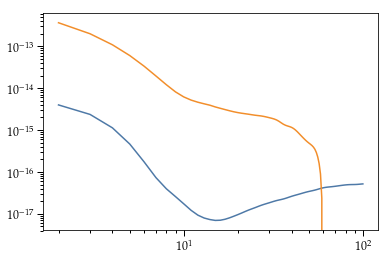

In [12]:

ell, ee, te = get_spectra(7, 0, spectra=True)
plt.loglog(ell[2:], ee[2:])
plt.loglog(ell[2:], te[2:])

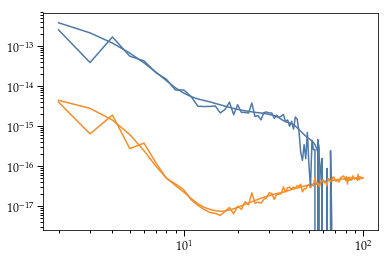

In [13]:
import healpy as hp
ell, ee, te, tt = get_spectra(7.5, 0.0, spectra=True, lmax=lmax, all_spectra=True)
plt.loglog(ell[2:], te[2:], color='C0')
plt.loglog(ell[2:], ee[2:], color='C1')
clhat = hp.alm2cl(hp.synalm(np.array([tt, ee, 0*ee, te]), lmax=lmax, new=True))
eehat = clhat[1]
tehat = clhat[3]
plt.loglog(ell[2:], tehat[2:], color='C0')
plt.loglog(ell[2:], eehat[2:], color='C1')

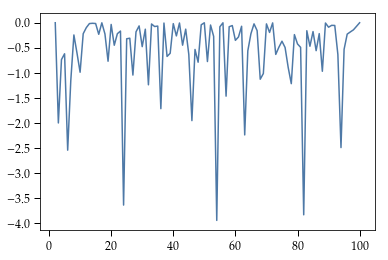

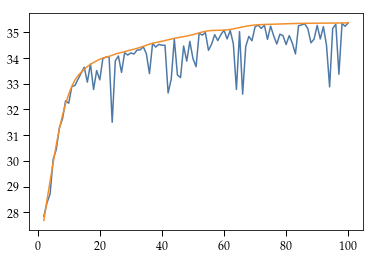

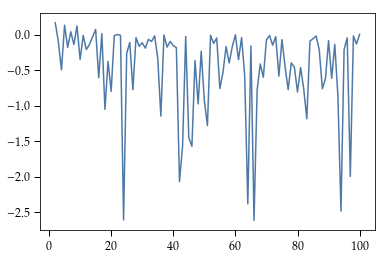

In [14]:
from scipy.special import polygamma, gamma, kv
from scipy.optimize import minimize
import warnings; warnings.simplefilter('ignore')

def lnprob_EE_ell(zre, x_e, Clhat, N_l=0):
    # This returns log(P)
    ell, Cl, TE = get_spectra(zre, x_e, lmax=len(Clhat)-1, spectra=True)
    Cl += N_l
    chi2_ell = (2*ell+1)*(Clhat/Cl + np.log(Cl/Clhat)-1)
    return -chi2_ell/2

def lnprob_wish_ell(zre, x_e, Clhat, N_lT=0, N_lE=0):
    # This returns log(P)
    TThat, EEhat, BBhat, TEhat, TBhat, EBhat = Clhat
    ell, ee, te, tt = get_spectra(zre, x_e,  spectra=True, lmax=len(EEhat)-1, all_spectra=True)

    tt += N_lT
    ee += N_lE
    n = 2
    Cl = np.array([[tt, te], [te, ee]])
    Clhat = np.array([[TThat, TEhat],[TEhat, EEhat]])
    Cl = np.array([[tt, te], [te, ee]])
    Clhat = np.array([[Clhats[0], Clhats[3]], [Clhats[3], Clhats[1]]])
    Cl = np.swapaxes(Cl, 1,2)
    Cl = np.swapaxes(Cl, 0,1)
    Clhat = np.swapaxes(Clhat, 1,2)
    Clhat = np.swapaxes(Clhat, 0,1)

    x = Clhat.dot(np.linalg.inv(Cl))
    chi2_ell = (2*ell+1)*(np.trace(x) + np.log(x)-n)
    return -chi2_ell/2


def prob_TE_ell(zre, x_e, TEhat):
    c = TEhat
    ell, EE, TE, TT = get_spectra(zre, x_e, lmax=len(TEhat)-1, spectra=True, all_spectra=True)
    ell, EE, _, TT = get_spectra(7, 0, lmax=len(TEhat)-1, spectra=True, all_spectra=True)

    rho = TE/np.sqrt(TT*EE)
    z = (1-rho**2)*np.sqrt(TT*EE)
    ell = np.arange(len(TT))
    N = 2*ell+1
    num = N**((N+1)/2)*abs(c)**((N-1)/2)*np.exp(N*rho*c/z)*kv((N-1)//2, N*abs(c)/z)
    den = 2**((N-1)/2)*np.sqrt(np.pi)*gamma(N/2)*np.sqrt(z)*(TT*EE)**(N/4)
    return num/den

def lnprob_TE_ell(zre, x_e, TEhat, N_TT=0, N_EE=0):
    c = TEhat
    ell, EE, TE, TT = get_spectra(zre, x_e, lmax=len(TEhat)-1, spectra=True, all_spectra=True)
    #ell, EE, _, TT = get_spectra(7, 0, lmax=len(TEhat)-1, spectra=True, all_spectra=True)

    N = 2*ell + 1
    sTT = (TT+N_TT)**0.5
    sEE = (EE+N_EE)**0.5
    rho = TE/sTT/sEE
    z = (1-rho**2)*(sTT*sEE)
    lnP = (N-1)/2*np.log(abs(c)) + N*rho*c/z + np.log( kv((N-1)//2, N*abs(c)/z)) - N/2*np.log(sTT*sEE) - 0.5*np.log(z)
    consts = (N+1)/2*np.log(N) - (N-1)/2*np.log(2)-0.5*np.log(np.pi)-np.log(gamma(N/2))
        #print(mu, var**0.5, res)
    # This normalizes to the mean, not the peak. Different things!
    #lnP0 = (N-1)/2*np.log(abs(TE)) +N*rho*TE/z + np.log( kv((N-1)//2, N*abs(TE)/z)) - N/2*np.log(sTT*sEE) - 0.5*np.log(z)
    return lnP + consts


lnP_ell = lnprob_EE_ell(7, 0, eehat)
plt.plot(ell[2:], lnP_ell[2:])

lnprob0_ell2 = lnprob_TE_ell(7, 0, te)
lnprob_ell2 = lnprob_TE_ell(7, 0, tehat)
probell2 = prob_TE_ell(7, 0, tehat)
plt.figure()
plt.plot(ell[2:], lnprob_ell2[2:])
plt.plot(ell[2:], lnprob0_ell2[2:])

plt.figure()
plt.plot(ell[2:], lnprob_ell2[2:] - lnprob0_ell2[2:])
def lnprob(args, Clhat):
    zre, x_e = args
    if (zre < 4) | (x_e < 0) | (x_e > 0.5):
        return -np.inf
    return sum(lnprob_EE_ell(zre, x_e, Clhat)[2:])

def lnprob_2D(args, Clhat):
    zre, x_e = args
    if (zre < 4) | (x_e < 0) | (x_e > 0.5):
        return -np.inf
    return sum(lnprob_EE_ell(zre, x_e, Clhat)[2:])

def lnprob_1D(args, Clhat):
    zre = args
    x_e = 0
    if (zre < 4) | (x_e < 0) | (x_e > 0.5):
        return -np.inf
    return sum(lnprob_EE_ell(zre, x_e, Clhat)[2:])




1.0
0.9999999999999996
1.0000000000000002
0.9999999999999999
0.9999999999999969
23558.169687011137 67.41320395529416 0.6231297927428816
0.5563972022844427


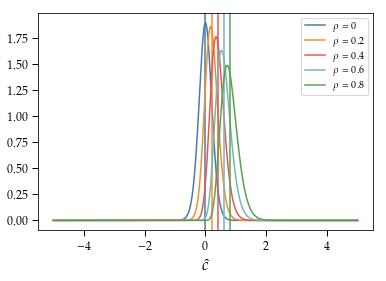

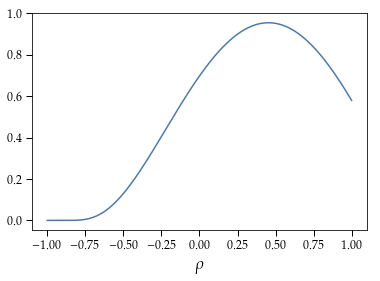

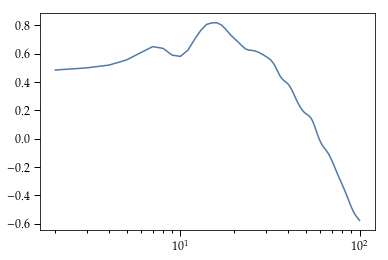

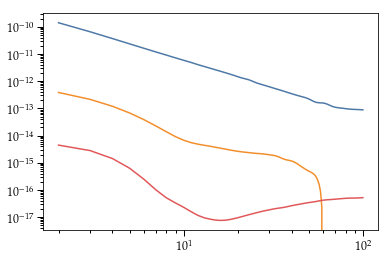

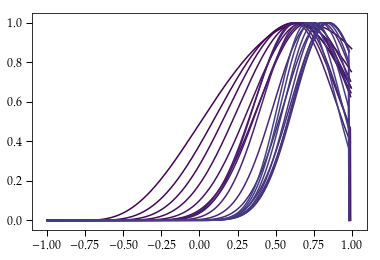

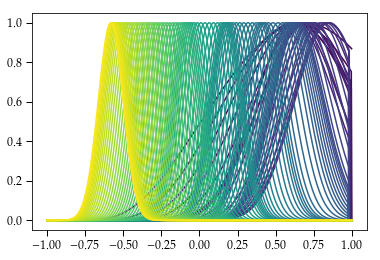

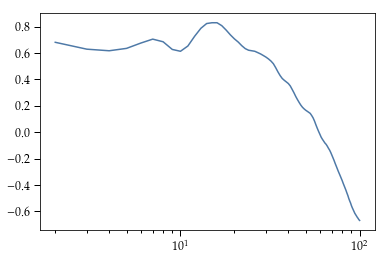

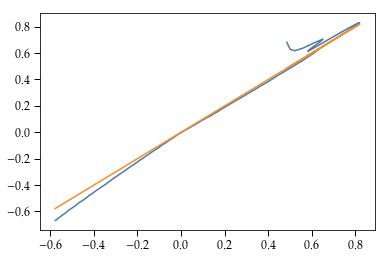

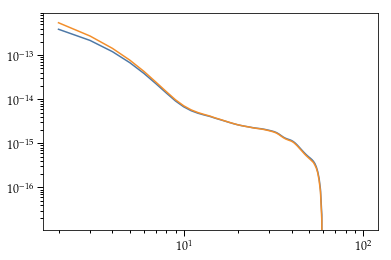

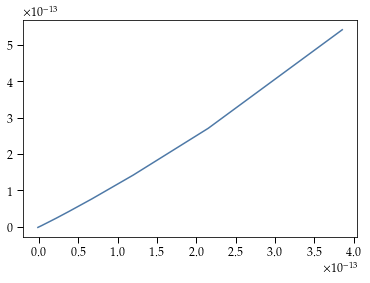

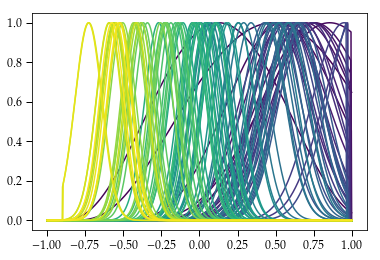

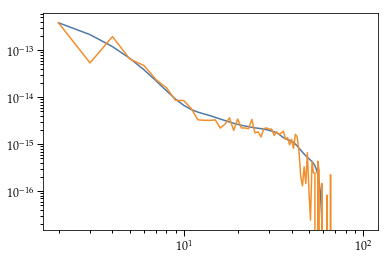

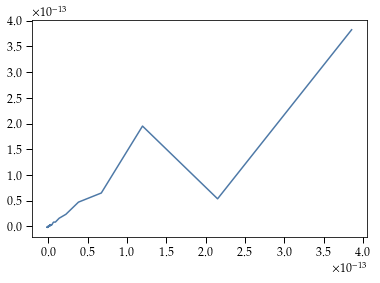

In [15]:
# consistency check

def p_AB(c, rho=0.5, ell=2, TT=100, EE=0.01, N_T=0, N_E=0):
    N = 2*ell + 1
    sTT = (TT+N_T)**0.5
    sEE = (EE+N_E)**0.5
    z = (1-rho**2)*(sTT*sEE)
    num = N**((N+1)/2)*abs(c)**((N-1)/2)*np.exp(N*rho*c/z)*kv((N-1)//2, N*abs(c)/z)
    den = 2**((N-1)/2)*np.pi**0.5*gamma(N/2)*np.sqrt(z)*(sTT*sEE)**(N/2)
    return num/den

def lnp_AB(c, rho=0.5, ell=2, TT=100, EE=0.01, N_T=0, N_E=0, lnP0=False):
    N = 2*ell + 1
    sTT = (TT+N_T)**0.5
    sEE = (EE+N_E)**0.5
    z = (1-rho**2)*(sTT*sEE)
    lnP = N*rho*c/z + np.log( kv((N-1)//2, N*abs(c)/z)) - N/2*np.log(sTT*sEE) - 0.5*np.log(z)
    consts = (N+1)/2*np.log(N) - (N-1)/2*np.log(2)-0.5*np.log(np.pi)-np.log(gamma(N/2))
    return lnP + consts

# p(xhat | rho, A, B, N)

from scipy.integrate import trapz
# p_AB should be maximized when chat = rho*sigmaA*sigmaB
c = np.linspace(-5, 5, 1000)
for i, rho in enumerate([0, 0.2, 0.4, 0.6, 0.8]):
    plt.plot(c, p_AB(c, rho=rho, ell=10), label=r'$\rho={}$'.format(rho), color=f'C{i}')
    print(trapz(p_AB(c, rho=rho, ell=10), x = c))
    plt.axvline(rho, color=f'C{i}')

plt.xlabel(r'$\hat c$')
plt.legend(loc='best')
    
c = 0.3
rho = np.linspace(-1, 1, 1000)
plt.figure()
plt.plot(rho, p_AB(c, rho=rho))
plt.xlabel(r'$\rho$')


plt.figure()
rhoth = te/np.sqrt(tt*ee)
plt.semilogx(ell[2:], rhoth[2:])
plt.figure()
plt.loglog(ell[2:], tt[2:])
plt.loglog(ell[2:], te[2:])
plt.loglog(ell[2:], ee[2:])


print(tt[5]*1e15, te[5]*1e15, ee[5]*1e15)
print(rhoth[5])

plt.figure()
for i, l in enumerate(ell[2:]):
    p = p_AB(te[l], TT=tt[l], EE=ee[l], ell=l, rho=rho)
    inds = np.isfinite(p)
    if sum(inds) > 0:
        pmax = p[inds].max()
        plt.plot(rho, p/pmax, color=plt.cm.viridis(i/len(ell[2:])))

rhohat = [0,0]
TEhat = [0,0]
plt.figure()
for i, l in enumerate(ell[2:]):
    lnp = lnp_AB(te[l], TT=tt[l], EE=ee[l], ell=l, rho=rho)
    inds = np.isfinite(lnp)
    if sum(inds) > 0:
        lnpmax = lnp[inds].max()
        plt.plot(rho, np.exp(lnp - lnpmax), color=plt.cm.viridis(i/len(ell[2:])))
        rhohat.append(rho[np.argmax(lnp[inds])])
        TEhat.append(rhohat[-1]*(tt[l]*ee[l])**0.5)
    else:
        rhohat.append(0)
        
plt.figure()
plt.semilogx(ell[2:], rhohat[2:])

plt.figure()
plt.plot(rhoth[2:], rhohat[2:])
plt.plot(rhoth[2:], rhoth[2:])



plt.figure()
plt.loglog(ell[2:], te[2:])
plt.loglog(ell[2:], TEhat[2:])
plt.figure()
plt.plot(te[2:], TEhat[2:])



rhohat = [0,0]
TEhat = [0,0]
plt.figure()
for i, l in enumerate(ell[2:]):
    lnp = lnp_AB(tehat[l], TT=tt[l], EE=ee[l], ell=l, rho=rho)
    inds = np.isfinite(lnp)
    if sum(inds) > 0:
        lnpmax = lnp[inds].max()
        plt.plot(rho, np.exp(lnp - lnpmax), color=plt.cm.viridis(i/len(ell[2:])))
        rhohat.append(rho[np.argmax(lnp[inds])])
        TEhat.append(rhohat[-1]*(tt[l]*ee[l])**0.5)
    else:
        rhohat.append(0)
plt.figure()
plt.loglog(ell[2:], te[2:])
plt.loglog(ell[2:], TEhat[2:])
plt.figure()
plt.plot(te[2:], TEhat[2:])


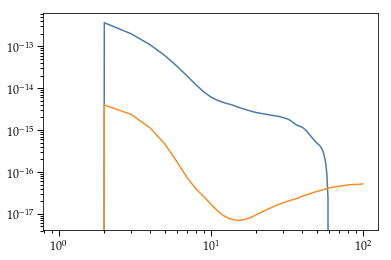

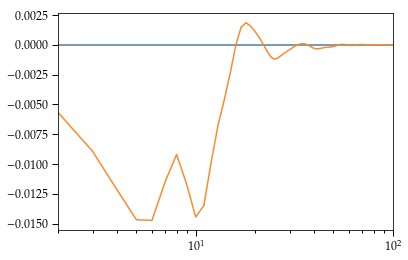

In [16]:

zs = np.linspace(6, 8, 25)
x_e0 = 0 
z0 = 7
ell, EE, TE = get_spectra(z0, x_e0, spectra=True)
PEEs = []
PTEs = []
lnpTE0 = lnprob_TE_ell(z0, x_e0, TE)
for i in range(len(zs)):
    lnpEE = lnprob_EE_ell(zs[i], x_e0, EE)
    lnpTE = lnprob_TE_ell(zs[i], x_e0, TE)
    PEEs.append(lnpEE)
    PTEs.append(lnpTE)

plt.loglog(ell, TE)
plt.loglog(ell, EE)

plt.figure()
lnpTE = lnprob_TE_ell(7, 0, TE)
plt.plot(ell, lnpTE - lnpTE0)
lnpTE = lnprob_TE_ell(7.1, 0, TE)
plt.plot(ell, lnpTE - lnpTE0)
plt.xlim([2,100])
plt.xscale('log')

Text(0, 0.5, '$\\mathcal L(z_\\mathrm{re}|{\\hat C_\\ell})$')

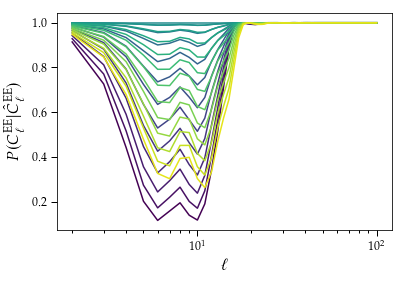

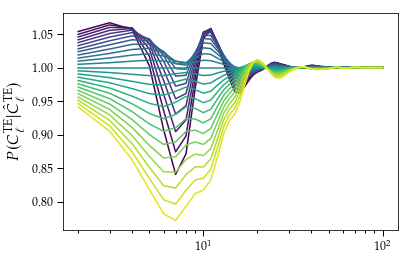

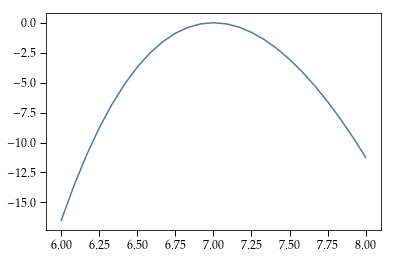

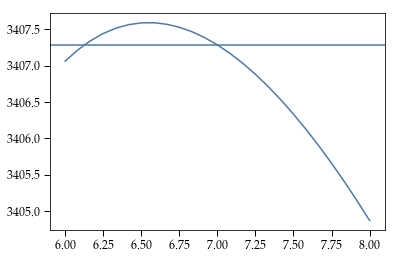

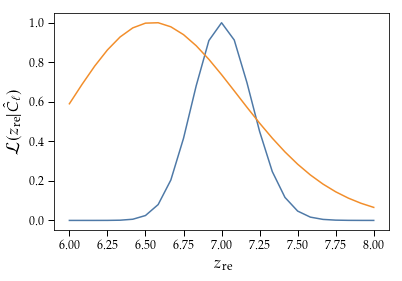

In [17]:
for i in range(len(zs)):
    plt.semilogx(ell, np.exp(PEEs[i]), color=plt.cm.viridis(i/len(zs)))
plt.xlabel(r'$\ell$')
plt.ylabel(r'$P(C_\ell^\mathrm{EE}|\hat C_\ell^\mathrm{EE})$')
# This uses specifically the normalization that lnL = 0 when \hat C = C.
plt.figure()
for i in range(len(zs)):
    plt.semilogx(ell, np.exp(PTEs[i] - lnpTE0), color=plt.cm.viridis(i/len(zs)))
plt.ylabel(r'$P(C_\ell^\mathrm{TE}|\hat C_\ell^\mathrm{TE})$')
# This is normalized to the "correct" answer. Interesting that there are oscillations in TE... is this because TT is changing?

lnPEEs = np.array(PEEs)
lnPTEs = np.array(PTEs)

lnPEE = np.sum(lnPEEs[:, 2:], axis=1)
lnPTE = np.sum(lnPTEs[:, 2:], axis=1)

plt.figure()
plt.plot(zs, lnPEE)
plt.figure()
plt.plot(zs, lnPTE)
plt.axhline(np.sum(lnpTE0[2:]))


plt.figure()
plt.plot(zs, np.exp(lnPEE-lnPEE.max()))
plt.plot(zs, np.exp(lnPTE-lnPTE.max()))
plt.xlabel(r'$z_\mathrm{re}$')
plt.ylabel(r'$\mathcal L(z_\mathrm{re}|{\hat C_\ell})$')

Text(0, 0.5, '$\\mathcal L(x_e^\\mathrm{min}|{\\hat C_\\ell})$')

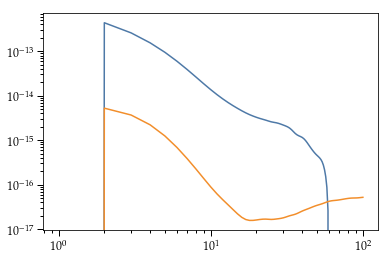

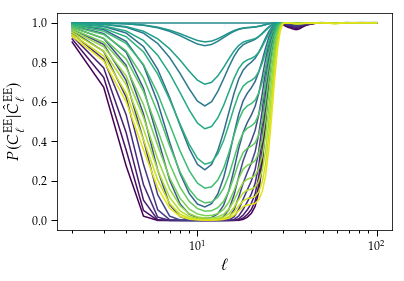

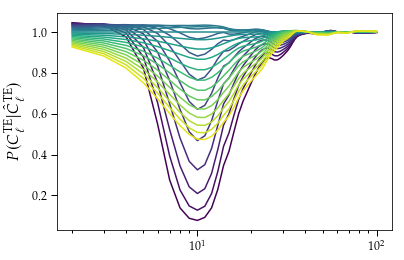

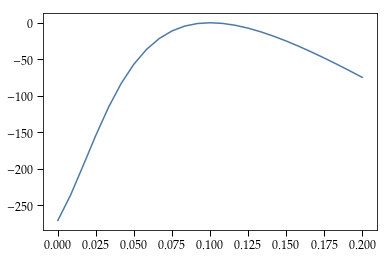

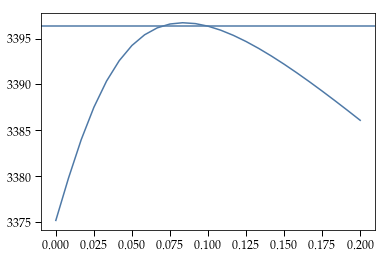

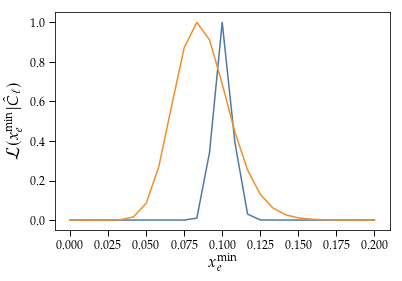

In [18]:

xes = np.linspace(0, 0.2, 25)
x_e0 = 0.1
z0 = 7
ell, EE, TE = get_spectra(z0, x_e0, spectra=True)
PEEs = []
PTEs = []
lnpTE0 = lnprob_TE_ell(z0, x_e0, TE)
for i in range(len(xes)):
    lnpEE = lnprob_EE_ell(z0, xes[i], EE)
    lnpTE = lnprob_TE_ell(z0, xes[i], TE)
    PEEs.append(lnpEE)
    PTEs.append(lnpTE)

plt.loglog(ell, TE)
plt.loglog(ell, EE)

plt.figure()
for i in range(len(xes)):
    plt.semilogx(ell, np.exp(PEEs[i]), color=plt.cm.viridis(i/len(xes)))
plt.xlabel(r'$\ell$')
plt.ylabel(r'$P(C_\ell^\mathrm{EE}|\hat C_\ell^\mathrm{EE})$')
# This uses specifically the normalization that lnL = 0 when \hat C = C.
plt.figure()
for i in range(len(xes)):
    plt.semilogx(ell, np.exp(PTEs[i] - lnpTE0), color=plt.cm.viridis(i/len(xes)))
plt.ylabel(r'$P(C_\ell^\mathrm{TE}|\hat C_\ell^\mathrm{TE})$')
# This is normalized to the "correct" answer. Interesting that there are oscillations in TE... is this because TT is changing?

lnPEEs = np.array(PEEs)
lnPTEs = np.array(PTEs)

lnPEE = np.sum(lnPEEs[:, 2:], axis=1)
lnPTE = np.sum(lnPTEs[:, 2:], axis=1)

plt.figure()
plt.plot(xes, lnPEE)
plt.figure()
plt.plot(xes, lnPTE)
plt.axhline(np.sum(lnpTE0[2:]))


plt.figure()
plt.plot(xes, np.exp(lnPEE-lnPEE.max()))
plt.plot(xes, np.exp(lnPTE-lnPTE.max()))
plt.xlabel(r'$x_e^\mathrm{min}$')
plt.ylabel(r'$\mathcal L(x_e^\mathrm{min}|{\hat C_\ell})$')

10
50
100
200


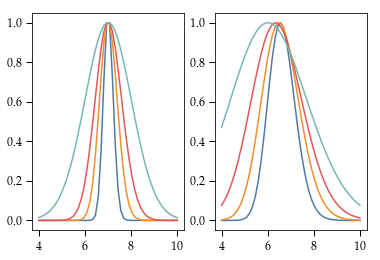

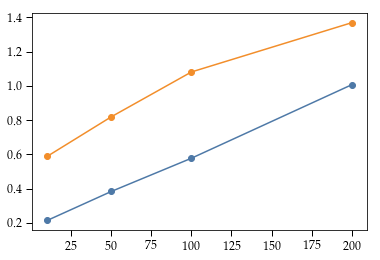

In [19]:
zs = np.linspace(4, 10, 50)
x_e0 = 0 
z0 = 7
ell, EE, TE = get_spectra(z0, x_e0, spectra=True)
lnpTE0 = lnprob_TE_ell(z0, x_e0, TE)
wps = np.array([10,50,100,200])
varEE = []
varTE = []
for wp in wps:
    Nl = (wp*np.pi/180/60)**2/((2.7e6)**2)
    PEEs = []
    PTEs = []
    print(wp)
    for i in range(len(zs)):
        lnpEE = lnprob_EE_ell(zs[i], x_e0, EE+2*Nl, N_l=2*Nl)
        lnpTE = lnprob_TE_ell(zs[i], x_e0, TE, N_EE=2*Nl, N_TT=Nl)
        PEEs.append(lnpEE)
        PTEs.append(lnpTE)
    PEEs = np.array(PEEs)
    PTEs = np.array(PTEs)
    lnpEE = np.sum(PEEs[:,2:], axis=1)
    lnpTE = np.sum(PTEs[:,2:], axis=1)
    plt.subplot(121)
    L = np.exp(lnpEE-lnpEE.max())
    mu = sum(L*zs)/sum(L)
    var = sum(L*zs**2)/sum(L) - mu**2
    varEE.append(var)
    plt.plot(zs, L)
    plt.subplot(122)
    L = np.exp(lnpTE-lnpTE.max())
    mu = sum(L*zs)/sum(L)
    var = sum(L*zs**2)/sum(L) - mu**2
    varTE.append(var)
    plt.plot(zs, L)
    
plt.figure()
plt.plot(wps, np.sqrt(varEE), 'o-')
plt.plot(wps, np.sqrt(varTE), 'o-')

10
50
100
200


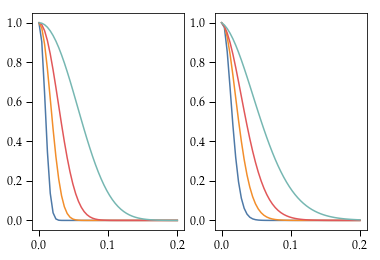

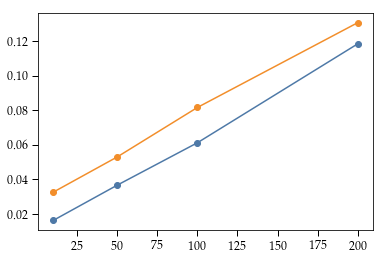

In [20]:
xes = np.linspace(0, 0.2, 50)
x_e0 = 0 
z0 = 7
ell, EE, TE = get_spectra(z0, x_e0, spectra=True)
lnpTE0 = lnprob_TE_ell(z0, x_e0, TE)
wps = np.array([10,50,100,200])
limEEs = []
limTEs = []
for wp in wps:
    Nl = (wp*np.pi/180/60)**2/((2.7e6)**2)
    PEEs = []
    PTEs = []
    print(wp)
    for i in range(len(zs)):
        lnpEE = lnprob_EE_ell(z0, xes[i], EE+2*Nl, N_l=2*Nl)
        lnpTE = lnprob_TE_ell(z0, xes[i], TE, N_EE=2*Nl, N_TT=Nl)
        PEEs.append(lnpEE)
        PTEs.append(lnpTE)
    PEEs = np.array(PEEs)
    PTEs = np.array(PTEs)
    lnpEE = np.sum(PEEs[:,2:], axis=1)
    lnpTE = np.sum(PTEs[:,2:], axis=1)
    plt.subplot(121)
    L = np.exp(lnpEE-lnpEE.max())
    limEEs.append(xes[np.where(L > 0.05)[0][-1]])
    plt.plot(xes, L)
    plt.subplot(122)
    L = np.exp(lnpTE-lnpTE.max())
    limTEs.append(xes[np.where(L > 0.05)[0][-1]])
    plt.plot(xes, L)
plt.figure()
plt.plot(wps, limEEs, 'o-')
plt.plot(wps, limTEs, 'o-')

0.1306122448979592


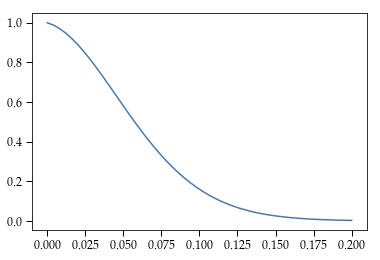

In [21]:
print(xes[np.where(L > 0.05)[0][-1]])
plt.plot(xes, L)

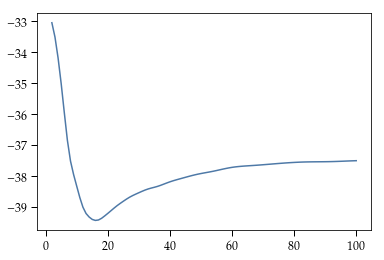

In [22]:
plt.plot(ell, np.log(ee))

In [23]:
def get_F(zre, xe, dzre=5e-3, dxre=1e-5, ell_arr=False, lmin=2, lmax=100, N_l=0):
    F = np.zeros((2,2))
    dlogCldzre = (np.log(get_EE_2D(zre+dzre, xe)+N_l) - np.log(get_EE_2D(zre, xe)+N_l))/dzre
    dlogCldxre = (np.log(get_EE_2D(zre, xe+dxre)+N_l) - np.log(get_EE_2D(zre, xe)+N_l))/dxre
    ell = np.arange(101)
    Fxx = sum(((2*ell+1)/2*dlogCldxre**2)[lmin:lmax+1])
    Fzz = sum(((2*ell+1)/2*dlogCldzre**2)[lmin:lmax+1])
    Fxz = sum(((2*ell+1)/2*dlogCldxre*dlogCldzre)[lmin:lmax+1])
    F = np.array([[Fzz,Fxz],[Fxz,Fxx]])
    if ell_arr:
        return (2*ell+1)/2*dlogCldzre**2, (2*ell+1)/2*dlogCldxre**2, (2*ell+1)/2*dlogCldxre*dlogCldzre
    else:
        return F

In [24]:
mean = np.array([7, 0.2])
F = get_F(*mean)
Finv = np.linalg.inv(F)

np.diag(np.linalg.inv(F))**0.5

array([0.72380897, 0.00847467])

[0.38855559 0.00481761]


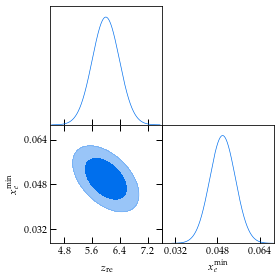

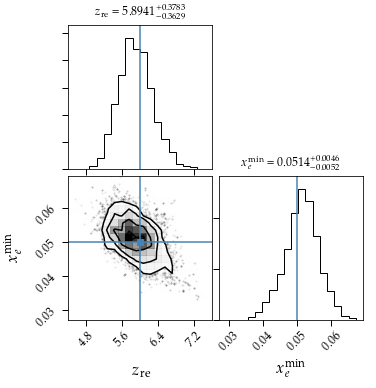

In [25]:
mean = np.array([6, 0.05])
F = get_F(*mean)
Finv = np.linalg.inv(F)
covariance = Finv
gauss=GaussianND(mean, covariance, labels=[r'$z_\mathrm{re}$', r'$x_e^\mathrm{min}$'])
g = plots.getSubplotPlotter()
g.triangle_plot(gauss, filled=True)
print(np.diag(Finv)**0.5)


fig = plt.gcf()

data = np.loadtxt('chain_5.dat')
chain = data.reshape((-1,24,3))
chain_cut = chain[100:].reshape(-1,3)
from corner import corner
ranges = [g.fig.axes[2].get_xlim(), g.fig.axes[2].get_ylim()]
fig = corner(chain_cut[:,-2:], truths=[6, 0.05], show_titles=True, title_fmt='.4f', range=ranges,
            labels=[r'$z_\mathrm{re}$', r'$x_e^\mathrm{min}$'])



Removed no burn in


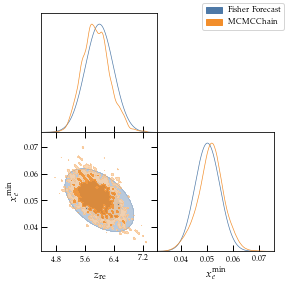

In [26]:
from getdist import MCSamples
labels = [r'$z_\mathrm{re}$', r'$x_e^\mathrm{min}$']
gauss=GaussianND(mean, covariance, names=labels, labels=labels, label='Fisher Forecast')
samples = MCSamples(samples=chain_cut[:,-2:], names=labels, labels=labels, label='MCMC Chain')
settings = plots.GetDistPlotSettings(subplot_size_inch=8)
g = plots.getSubplotPlotter(settings=settings)
g.triangle_plot([gauss, samples], filled=True, contour_colors=['C0', 'C1'])


In [27]:
    xe = 0.1
    zre = 6
    dzre = 1e-1
    dxre = 1e-2
    dlogCldxre = (np.log(get_EE(xe+dxre, zre)) - np.log(get_EE(xe, zre)))/dxre
    dlogCldzre = (np.log(get_EE(xe, zre+dzre)) - np.log(get_EE(xe, zre)))/dzre


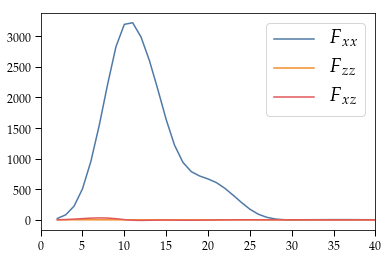

In [28]:
ell = np.arange(101)
plt.loglog(ell, (2*ell+1)/2*dlogCldxre**2, label=r'$F_{xx}$')
plt.loglog(ell, (2*ell+1)/2*dlogCldzre**2, label=r'$F_{zz}$')
plt.loglog(ell, (2*ell+1)/2*dlogCldzre*dlogCldxre, label=r'$F_{xz}$')
plt.xscale('linear')
plt.yscale('linear')
plt.xlim([0, 40])
plt.legend(loc='best', fontsize=20)

In [29]:
Fxx_l = (2*ell+1)/2*dlogCldxre**2
Fzz_l = (2*ell+1)/2*dlogCldzre**2
Fxz_l = (2*ell+1)/2*dlogCldzre*dlogCldxre

Fxx = sum(Fxx_l[2:])
Fzz = sum(Fzz_l[2:])
Fxz = sum(Fxz_l[2:])
F = np.array([[Fxx, Fxz],[Fxz,Fzz]])
print(F)
print(np.linalg.inv(F))
print(np.diag(np.linalg.inv(F))**0.5)

[[3.06583913e+04 9.11100882e+01]
 [9.11100882e+01 4.17743008e+00]]
[[ 3.48781166e-05 -7.60694545e-04]
 [-7.60694545e-04  2.55972434e-01]]
[0.00590577 0.50593718]


In [30]:
z = 6
lmax = 100
x_e = 0.1
ell = np.arange(lmax+1)
num = 30
Fll = np.zeros(num)
Fll2 = np.zeros(num)
dzs = np.logspace(-4, np.log10(6), num)
'''
y = get_EE_2D(z, x_e, lmax=lmax)
den = y
for i, dz in enumerate(dzs):
    dy = get_EE_2D(z+dz, x_e, lmax=lmax)
    dCldz = (dy - y)/dz
    plt.figure(1)
    plt.loglog(ell[2:], (2*ell[2:]+1)/2*(dCldz[2:]*dz/den[2:])**2, color=plt.cm.viridis(i/len(dzs)))
    Fll[i] = sum( (2*ell[2:]+1)/2*(dCldz[2:]/den[2:])**2)
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$F_{zz}\times\delta z^2$')
    plt.title(r'Uses $(dC_\ell/dz)/C_\ell$')
    
    dlogCldz = (np.log(dy) - np.log(y))/dz
    plt.figure(2)
    plt.loglog(ell[2:], (2*ell[2:]+1)/2*(dlogCldz[2:]*dz)**2, color=plt.cm.viridis(i/len(dzs)))
    Fll2[i] = sum( (2*ell[2:]+1)/2*dlogCldz[2:]**2)
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$F_{zz}\times\delta z^2$')
    plt.title(r'Uses $d (\log C_\ell)/dz$')

    plt.figure(3)
    t = (2*ell[2:]+1)/2*(dlogCldz[2:]*dz)**2
    plt.loglog(ell[2:], (2*ell[2:]+1)/2*abs((dCldz[2:]*dz/den[2:])**2 -  (dlogCldz[2:]*dz)**2)/t,
              color=plt.cm.viridis(i/len(dzs)))

plt.figure()
for i in range(len(dzs)):
    plt.semilogx(dzs[i], Fll[i], 'o', color=plt.cm.viridis(i/len(dzs)))
for i in range(len(dzs)):
    plt.semilogx(dzs[i], Fll2[i], 'o', color=plt.cm.viridis(i/len(dzs)))
plt.semilogx(dzs, Fll, label='Derivative of Cl')
plt.semilogx(dzs, Fll2, label='Derivative of log(Cl)')
plt.xlabel(r'$\delta z$')
plt.ylim([4, 5])
plt.legend(loc='best')
print(1/Fll**0.5)
'''

"\ny = get_EE_2D(z, x_e, lmax=lmax)\nden = y\nfor i, dz in enumerate(dzs):\n    dy = get_EE_2D(z+dz, x_e, lmax=lmax)\n    dCldz = (dy - y)/dz\n    plt.figure(1)\n    plt.loglog(ell[2:], (2*ell[2:]+1)/2*(dCldz[2:]*dz/den[2:])**2, color=plt.cm.viridis(i/len(dzs)))\n    Fll[i] = sum( (2*ell[2:]+1)/2*(dCldz[2:]/den[2:])**2)\n    plt.xlabel(r'$\\ell$')\n    plt.ylabel(r'$F_{zz}\times\\delta z^2$')\n    plt.title(r'Uses $(dC_\\ell/dz)/C_\\ell$')\n    \n    dlogCldz = (np.log(dy) - np.log(y))/dz\n    plt.figure(2)\n    plt.loglog(ell[2:], (2*ell[2:]+1)/2*(dlogCldz[2:]*dz)**2, color=plt.cm.viridis(i/len(dzs)))\n    Fll2[i] = sum( (2*ell[2:]+1)/2*dlogCldz[2:]**2)\n    plt.xlabel(r'$\\ell$')\n    plt.ylabel(r'$F_{zz}\times\\delta z^2$')\n    plt.title(r'Uses $d (\\log C_\\ell)/dz$')\n\n    plt.figure(3)\n    t = (2*ell[2:]+1)/2*(dlogCldz[2:]*dz)**2\n    plt.loglog(ell[2:], (2*ell[2:]+1)/2*abs((dCldz[2:]*dz/den[2:])**2 -  (dlogCldz[2:]*dz)**2)/t,\n              color=plt.cm.viridis(i/len(dzs)))\n

In [31]:
z = 6
lmax = 100
x_e = 0.1
ell = np.arange(lmax+1)
num = 30
Fll1 = np.zeros(num)
Fll2 = np.zeros(num)
'''

y = get_EE_2D(z, x_e, lmax=lmax)
logy = np.log(y)
dxes = np.logspace(-8, -2, num)
for i, dxe in enumerate(dxes):
    print(dxe)
    dy = get_EE_2D(z, x_e+dxe, lmax=lmax)
    dlogCldxe = (np.log(dy) - logy)/dxe
    dCldxe = (dy - y)/dxe
    den = y
    plt.figure(1)
    plt.loglog(ell[2:], (2*ell[2:]+1)/2*(dCldxe[2:]*dxe/den[2:])**2, color=plt.cm.viridis(i/len(dxes)))
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$F_{xx}\times\delta x^2$')
    plt.title(r'Uses $(dC_\ell/dx)/C_\ell$')
    
    plt.figure(2)
    plt.loglog(ell[2:], (2*ell[2:]+1)/2*(dlogCldxe[2:]*dxe)**2, color=plt.cm.viridis(i/len(dxes)))
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$F_{xx}\times\delta x^2$')
    plt.title(r'Uses $d (\log C_\ell)/dx$')

    plt.figure(3)
    t = (2*ell[2:]+1)/2*(dlogCldxe[2:]*dxe)**2
    plt.loglog(ell[2:], (2*ell[2:]+1)/2*abs((dCldxe[2:]*dxe/den[2:])**2 -  (dlogCldxe[2:]*dxe)**2)/t,
              color=plt.cm.viridis(i/len(dxes)))
    Fll1[i] = sum( (2*ell[2:]+1)/2*(dCldxe[2:]/den[2:])**2)
    Fll2[i] = sum( (2*ell[2:]+1)/2*(dlogCldxe[2:])**2)

plt.figure()
for i in range(len(dxes)):
    plt.semilogx(dxes[i], Fll1[i], 'o', color=plt.cm.viridis(i/len(dxes)))
for i in range(len(dxes)):
    plt.semilogx(dxes[i], Fll2[i], 'o', color=plt.cm.viridis(i/len(dxes)))
plt.xlabel(r'$\delta x_e$')
plt.semilogx(dxes, Fll1, label='Derivative of Cl')
plt.semilogx(dxes, Fll2, label='Derivative of log(Cl)')
plt.ylabel(r'$F_{xx}$')
plt.legend(loc='best')
    
print(1/Fll1**0.5)
'''


"\n\ny = get_EE_2D(z, x_e, lmax=lmax)\nlogy = np.log(y)\ndxes = np.logspace(-8, -2, num)\nfor i, dxe in enumerate(dxes):\n    print(dxe)\n    dy = get_EE_2D(z, x_e+dxe, lmax=lmax)\n    dlogCldxe = (np.log(dy) - logy)/dxe\n    dCldxe = (dy - y)/dxe\n    den = y\n    plt.figure(1)\n    plt.loglog(ell[2:], (2*ell[2:]+1)/2*(dCldxe[2:]*dxe/den[2:])**2, color=plt.cm.viridis(i/len(dxes)))\n    plt.xlabel(r'$\\ell$')\n    plt.ylabel(r'$F_{xx}\times\\delta x^2$')\n    plt.title(r'Uses $(dC_\\ell/dx)/C_\\ell$')\n    \n    plt.figure(2)\n    plt.loglog(ell[2:], (2*ell[2:]+1)/2*(dlogCldxe[2:]*dxe)**2, color=plt.cm.viridis(i/len(dxes)))\n    plt.xlabel(r'$\\ell$')\n    plt.ylabel(r'$F_{xx}\times\\delta x^2$')\n    plt.title(r'Uses $d (\\log C_\\ell)/dx$')\n\n    plt.figure(3)\n    t = (2*ell[2:]+1)/2*(dlogCldxe[2:]*dxe)**2\n    plt.loglog(ell[2:], (2*ell[2:]+1)/2*abs((dCldxe[2:]*dxe/den[2:])**2 -  (dlogCldxe[2:]*dxe)**2)/t,\n              color=plt.cm.viridis(i/len(dxes)))\n    Fll1[i] = sum( (2*el

(0, 100)

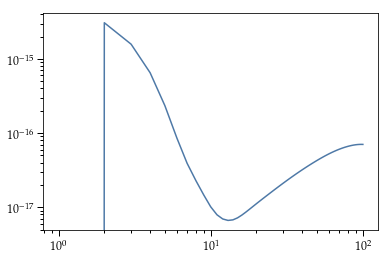

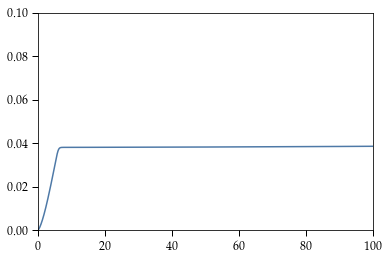

In [32]:
# How do the tau 1D chain compare to the Fisher forecast?

params = {
    'output': 'tCl pCl lCl',
    'l_max_scalars': lmax,
    'lensing': 'yes',
    'A_s': 2.3e-9,
    'n_s': 0.965,
    'z_reio':6}

cosmo = Class()
cosmo.set(params)
cosmo.compute()

def get_EE(zrei, lmax=100):
    params['z_reio'] = zrei
    cosmo.set(params)
    cosmo.compute()
    thermo = cosmo.get_thermodynamics()
    tau = get_tau(thermo)
    params['A_s'] = 2.3e-9*np.exp(-2*0.06)/np.exp(-2*tau)
    cosmo.set(params)
    cosmo.compute()
    cls = cosmo.lensed_cl(lmax)
    #cosmo.struct_cleanup()
    return cls['ee']

def get_EE_1D(zrei, lmax=100):
    params['z_reio'] = zrei
    cosmo.set(params)
    cosmo.compute()
    thermo = cosmo.get_thermodynamics()
    tau = get_tau(thermo)
    params['A_s'] = 2.3e-9*np.exp(-2*0.06)/np.exp(-2*tau)
    cosmo.set(params)
    cosmo.compute()
    cls = cosmo.lensed_cl(lmax)
    #cosmo.struct_cleanup()
    return cls['ee']
ell = np.arange(lmax+1)

plt.loglog(ell, get_EE(6, lmax=lmax))

thermo = cosmo.get_thermodynamics()


plt.figure()
z, tau_z = get_tau_z(thermo)
plt.plot(z[1:], tau_z)
plt.ylim([0,0.1])
plt.xlim([0, 100])


In [33]:
z = 6
dz = 1e-1
dlogCldz = (np.log(get_EE(z+dz)) - np.log(get_EE(z)))/dz


6 0.1


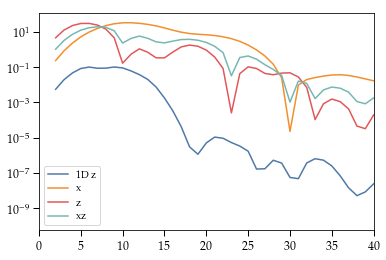

In [34]:
ell = np.arange(101)
plt.plot((2*ell+1)/2*dlogCldz**2/z**2, label='1D z')
#Fxx_l = (2*ell+1)/2*dlogCldxre**2
#Fzz_l = (2*ell+1)/2*dlogCldzre**2
#Fxz_l = (2*ell+1)/2*dlogCldzre*dlogCldxre
plt.plot(Fxx_l*x_e**2, label='x')
plt.plot(Fzz_l*z**2, label='z')
plt.plot(abs(Fxz_l)*z*x_e, label='xz')
plt.xlim([0,40])
plt.yscale('log')
plt.legend(loc='best')
print(z, x_e)

In [35]:
F_zz0 = (2*ell+1)/2*dlogCldz**2
print(1/sum(F_zz0[2:])**0.5)
print(1/sum(Fzz_l[2:])**0.5)
print(1/sum(Fxz_l[2:])**0.5)
print(1/sum(Fxx_l[2:])**0.5)

0.1944147644554231
0.489266414710283
0.10476513248449022
0.005711173031948873


Text(0.5, 1.0, 'Constraining instantaneous reionization')

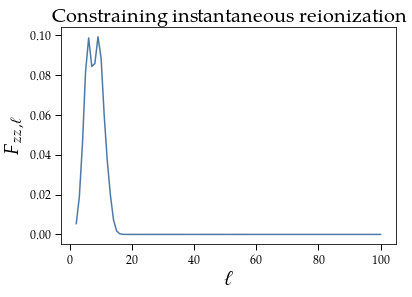

In [36]:
plt.plot((2*ell+1)/2*dlogCldz**2/z**2)
plt.xlabel(r'$\ell$', size=20)
plt.ylabel(r'$F_{zz,\ell}$', size=20)
plt.title('Constraining instantaneous reionization', size=20)

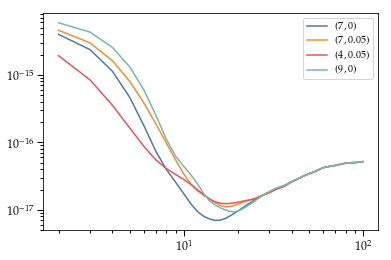

In [37]:
# Write a poor man's MCMC for the different likelihoods
params = {
    'output': 'tCl pCl lCl',
    'l_max_scalars': lmax,
    'lensing': 'yes',
    'A_s': 2.3e-9,
    'n_s': 0.965,
    'z_reio':7}
cosmo.empty()
del params['z_reio']
params['reio_parametrization'] ='reio_many_tanh'
params['many_tanh_num'] = 3
params['many_tanh_width'] = 0.5
plt.loglog(ell[2:], get_EE_2D(7, 0, lmax=ell.max())[2:], label=r'$(7, 0)$')
plt.loglog(ell[2:], get_EE_2D(7, 0.05, lmax=ell.max())[2:], label=r'$(7, 0.05)$')
plt.loglog(ell[2:], get_EE_2D(4, 0.05, lmax=ell.max())[2:], label=r'$(4, 0.05)$')
plt.loglog(ell[2:], get_EE_2D(9, 0, lmax=ell.max())[2:], label=r'$(9, 0)$')
plt.legend(loc='best')

In [38]:
#plt.plot(dzs, Fll)
print(np.array_repr(dzs))
print(np.array_repr(Fll))
# same multipoles being used? for fisher and MCMC? Do a 1D posterior
# Gry and figure out where things are numerically going wrong...
# If there's a persistent difference in the 1D versus Fisher... that's good to keep in mind.
# Look at the inferred Fisher matrix as well as those plots...

array([1.00000000e-04, 1.46138228e-04, 2.13563816e-04, 3.12098376e-04,
       4.56095035e-04, 6.66529201e-04, 9.74053962e-04, 1.42346520e-03,
       2.08022681e-03, 3.04000660e-03, 4.44261176e-03, 6.49235410e-03,
       9.48781121e-03, 1.38653192e-02, 2.02625317e-02, 2.96113047e-02,
       4.32734359e-02, 6.32390323e-02, 9.24164011e-02, 1.35055691e-01,
       1.97367993e-01, 2.88430087e-01, 4.21506617e-01, 6.15982300e-01,
       9.00185616e-01, 1.31551531e+00, 1.92247075e+00, 2.80946469e+00,
       4.10570190e+00, 6.00000000e+00])
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [39]:

def lnprob_2D(args, Clhat):
    zre, x_e = args
    if (zre < 4) | (x_e < 0) | (x_e > 0.5):
        return -np.inf
    return sum(lnprob_EE_ell(zre, x_e, Clhat)[2:])

def lnprob_1D(args, Clhat):
    zre = args
    x_e = 0
    if (zre < 4) | (x_e < 0) | (x_e > 0.5):
        return -np.inf
    return sum(lnprob_EE_ell(zre, x_e, Clhat)[2:])

def lnprob_2D_wish(args, Clhat):
    zre, x_e = args
    if (zre < 4) | (x_e < 0) | (x_e > 0.5):
        return -np.inf
    return sum(lnprob_wish_ell(zre, x_e, Clhat)[2:])

def lnprob_1D_wish(args, Clhat):
    zre = args
    x_e = 0
    if (zre < 4) | (x_e < 0) | (x_e > 0.5):
        return -np.inf
    return sum(lnprob_wish_ell(zre, x_e, Clhat)[2:])


print(lnprob_2D(np.array([7, 0]), eehat[:lmax+1]))
print(lnprob_1D(7, eehat[:lmax+1]))

-55.72527832900648
-55.72527832900648


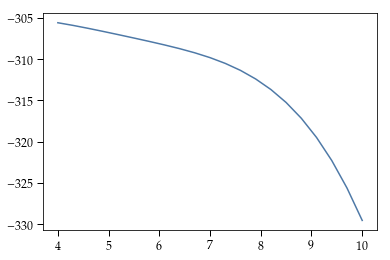

In [40]:
z = np.linspace(4, 10, 21)
lnP = np.zeros_like(z)
for i in range(len(z)):
    lnP[i] = lnprob_2D(np.array([z[i],0.2]), eehat[:lmax+1])
plt.plot(z, lnP)

4.59907088589756 0.6597667517257356


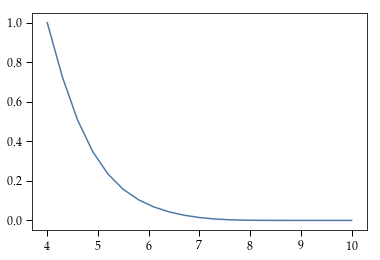

In [41]:
L = np.exp(lnP-lnP.max())
zbar = sum(z*L)/sum(L)
z2 = sum(z**2*L)/sum(L)
sd = (z2 - zbar**2)**0.5
print(zbar, sd)
plt.plot(z, L)

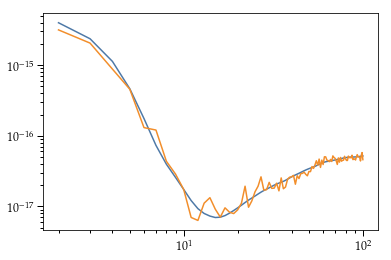

In [42]:
ell, ee, te = get_spectra(7, 0, spectra=True, lmax=lmax)
plt.loglog(ell[2:], ee[2:])
eehat = hp.alm2cl(hp.synalm(ee, lmax=lmax))
plt.loglog(ell[2:], eehat[2:])

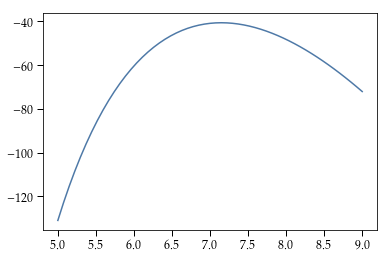

In [43]:
z = np.linspace(5, 9, 55)
lnP = np.zeros_like(z)
for i in range(len(z)):
    lnP[i] = lnprob_2D(np.array([z[i],0]), eehat[:lmax+1])
plt.plot(z, lnP)

7.159032709338918 0.20426431165978787


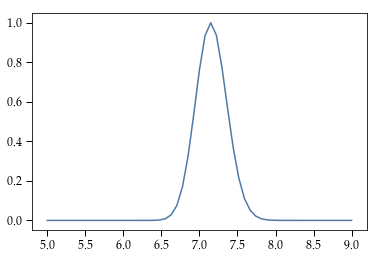

In [44]:
L = np.exp(lnP-lnP.max())
zbar = sum(z*L)/sum(L)
z2 = sum(z**2*L)/sum(L)
sd = (z2 - zbar**2)**0.5
print(zbar, sd)
plt.plot(z, L)

In [45]:
cosmo.struct_cleanup()
cosmo.empty()


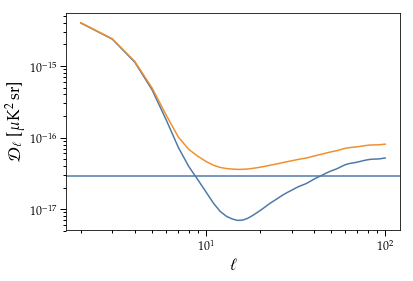

In [46]:
'''
def get_F(zre, xe, dzre = 0.5, dxre = 1e-2, N_l = 0):
    F = np.zeros((2,2))
    dlogCldxre = (np.log(get_EE_2D(zre, xe+dxre)+N_l) - np.log(get_EE_2D(zre, xe)+N_l))/dxre
    dlogCldzre = (np.log(get_EE_2D(zre+zre, xe)+N_l) - np.log(get_EE_2D(zre, xe)+N_l))/dzre
    ell = np.arange(101)
    Fxx = sum(((2*ell+1)/2*dlogCldxre**2)[2:])
    Fzz = sum(((2*ell+1)/2*dlogCldzre**2)[2:])
    Fxz = sum(((2*ell+1)/2*dlogCldxre*dlogCldzre)[2:])
    F = np.array([[Fzz,Fxz],[Fxz,Fxx]])
    return F
'''
plt.loglog(ell[2:], get_EE_2D(7, 0)[2:])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\mathcal D_\ell$ [$\mathrm{\mu K^2\,sr}$]')

wp = 50 # uK-arcmin
N_l = (wp*np.pi/180/60)**2/((2.7e6)**2)
plt.loglog(ell[2:], get_EE_2D(7, 0)[2:] + N_l)
plt.axhline(N_l)

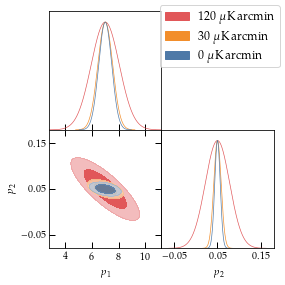

In [47]:
wps = np.arange(0, 110, 20)
wps = np.array([cv_noise, class_noise, planck_noise])
F = []

for wp in wps:
    F.append(get_F(7, 0.1, N_l=(wp*np.pi/180/60)**2/((2.7e6)**2)))

gausses = []
mean = np.array([7, 0.05])
for i in range(len(F)):
    cov = np.linalg.inv(F[i])
    gauss = GaussianND(mean, cov, label=r'${0}\ \mathrm{{\mu K\,arcmin}}$'.format(wps[i]))
    gausses.append(gauss)

g = plots.getSubplotPlotter()
g.triangle_plot(gausses[::-1], filled=True, colors=['C2', 'C1', 'C0'], contour_colors=['C2','C1','C0'])
plt.savefig('contours.png', dpi=300)

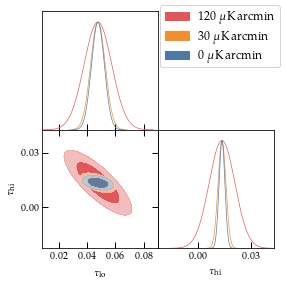

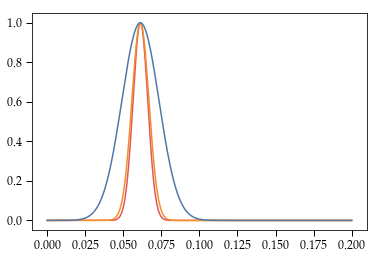

In [48]:
wps = np.arange(0, 110, 20)
wps = np.array([cv_noise, class_noise, planck_noise])
F = []

TransMat = np.array([[1/dtaulodz**2, 1/dtaulodz/dtauhidx],
                     [1/dtaulodz/dtauhidx, 1/dtauhidx**2]])

for wp in wps:
    F.append(get_F(7, 0.1, N_l=(wp*np.pi/180/60)**2/((2.7e6)**2)))

gausses = []
mean = np.array([7, 0.05])
taulo, tauhi, tautot = get_taus_simp(7, 0.05)
mean = np.array([taulo, tauhi])
tauvars = []
for i in range(len(F)):
    cov = np.linalg.inv(F[i]*TransMat)
    gauss = GaussianND(mean, cov, labels=[r'$\tau_\mathrm{lo}$', r'$\tau_\mathrm{hi}$'], 
                                          label=r'${0}\ \mathrm{{\mu K\,arcmin}}$'.format(wps[i]))
    gausses.append(gauss)
    tauvars.append(sum(np.diag(cov)))

g = plots.getSubplotPlotter()
g.triangle_plot(gausses[::-1], filled=True, colors=['C2', 'C1', 'C0'], contour_colors=['C2','C1','C0'])
plt.savefig('contours.png', dpi=300)

plt.figure()
tau_arr = np.linspace(0, 0.2, 1000)
for i in range(len(F)):
    G = np.exp(-(tautot-tau_arr)**2/(2*tauvars[i]))
    plt.plot(tau_arr, G, color='C{0}'.format(2-i))

0.4915197397134087
0.49151973971340873 0.005563505106567606
4.139215826614418 4.139215826614418


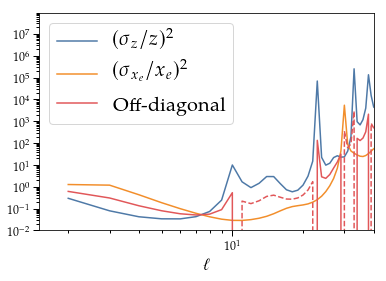

In [49]:
F_zzl, F_xxl, F_xzl = get_F(6, 0.1, ell_arr=True)

sigma_zl = 1/F_zzl**0.5
sigma_xl = 1/F_xxl**0.5
rho_xzl = 1/F_xzl
plt.plot(ell[2:], (sigma_zl[2:]/6)**2, label=r'$(\sigma_z/z)^2$')
plt.plot(ell[2:], (sigma_xl[2:]/0.1)**2, label=r'$(\sigma_{x_e}/{x_e})^2$')
plt.plot(ell[2:], rho_xzl[2:]/6/0.1, label='Off-diagonal')
plt.plot(ell[2:], -rho_xzl[2:]/6/0.1, 'C2--')

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.legend(loc='best', fontsize=20)
plt.xlim([1.5, 40])
#plt.ylim([0.1, 205])
print(sum(1/sigma_zl[2:]**2)**-0.5)

F = get_F(6, 0.1)
print(1/F[0,0]**0.5, 1/F[1,1]**0.5)
print(sum(F_zzl[2:]), F[0,0])


(2, 2, 101)
[[ 1.37430871e+12 -1.58496423e+10]
 [-1.58496423e+10  2.00191823e+08]]
[[ 2.58202635e-01 -7.41285474e-04]
 [-7.41285474e-04  3.30807786e-05]]


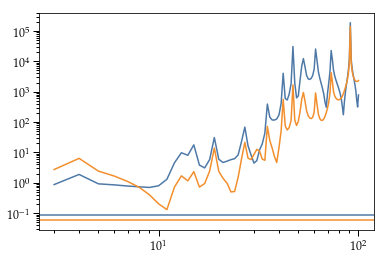

In [50]:
F_l = np.array([[F_zzl, F_xzl], [F_xzl, F_xxl]])
print(F_l.shape)
Finv_l = []
for i in range(len(ell)-1):
    Finv_l.append(np.linalg.inv(F_l[:,:,i]+F_l[:,:,i+1]))
Finv_l = np.array(Finv_l)

plt.plot(ell[3:], Finv_l[2:,0,0]**0.5/6)
plt.plot(ell[3:], Finv_l[2:,1,1]**0.5/0.1)

plt.yscale('log')
plt.xscale('log')
Finv_l[2]

print(np.sum(Finv_l[2:], axis=0))
print(np.linalg.inv(F))
Finv = np.linalg.inv(F)
plt.axhline(Finv[0,0]**0.5/6, color='C0')
plt.axhline(Finv[1,1]**0.5/0.1, color='C1')


In [51]:
print(np.linalg.inv(get_F(6,0.1, lmax=10)))
print(np.linalg.inv(get_F(6,0.1, lmin=5, lmax=15)))

[[ 5.11051663e-01 -6.33765812e-03]
 [-6.33765812e-03  1.59246305e-04]]
[[ 4.07136324e-01 -1.60731897e-03]
 [-1.60731897e-03  4.57924099e-05]]


0.4915197397134088 6.124876937557474e-05


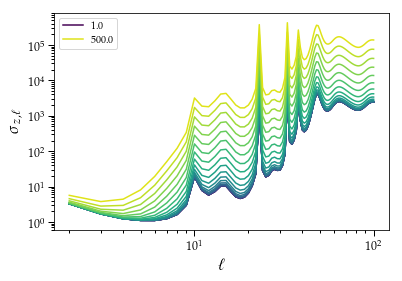

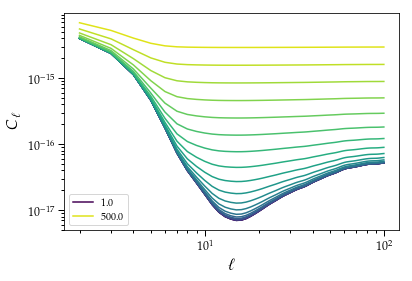

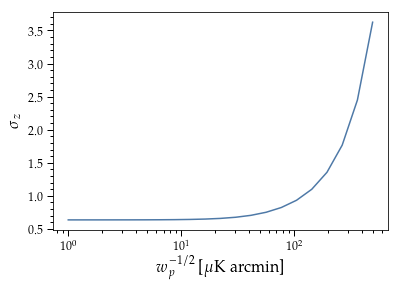

In [52]:
# It's in F_zz,l.
sigma_z = np.sqrt(1/sum(F_zzl[2:]))
sigma_zl = np.sqrt(1/F_zzl)
print(sigma_z, 1/sum(sigma_zl[2:]**2)**0.5)

wp = 50 # uK-arcmin
N_l = (wp*np.pi/180/60)**2/((2.7e6)**2)
C_l =  get_EE_2D(7, 0)[2:]

plt.figure()
sigma_zs = []
wps = np.logspace(0, 2+np.log10(5), 21)
wps[-1] = 500
for i, wp in enumerate(wps):
    N_l = (wp*np.pi/180/60)**2/((2.7e6)**2)
    if (i == 0) | (i == len(wps)-1):
        plt.figure(1)
        plt.plot(ell[2:], sigma_zl[2:]*(1+N_l/C_l), label=wp, color=plt.cm.viridis(i/len(wps)))
        plt.figure(2)
        plt.plot(ell[2:], C_l+N_l, label=wp, color=plt.cm.viridis(i/len(wps)))
    else:
        plt.figure(1)
        plt.plot(ell[2:], sigma_zl[2:]*(1+N_l/C_l), color=plt.cm.viridis(i/len(wps)))
        plt.figure(2)
        plt.plot(ell[2:], C_l+N_l, color=plt.cm.viridis(i/len(wps)))


    sigma_zs.append( sum(1/(sigma_zl[2:]**2*(1+N_l/C_l))**2)**-0.5  )
plt.figure(1)
plt.legend(loc='best')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\sigma_{z,\ell}$')
plt.savefig('sigmaz_ell.png', bbox_inches='tight', dpi=300)
plt.figure(2)
plt.legend(loc='best')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')

# Right, it's the "as a function of noise" thing.
plt.figure()
plt.plot(wps, sigma_zs)
plt.xscale('log')
plt.xlabel(r'$w_p^{-1/2}$ [$\mathrm{\mu K\ arcmin}$]')
plt.ylabel(r'$\sigma_z$')
plt.minorticks_on()
plt.savefig('sigmaz.png', bbox_inches='tight', dpi=300)

0.005563505106567606 0.001480365561877642


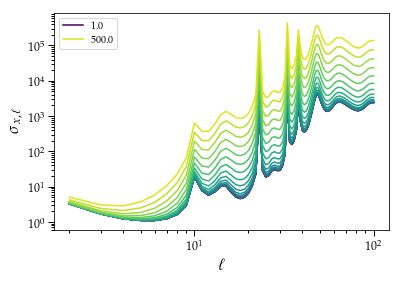

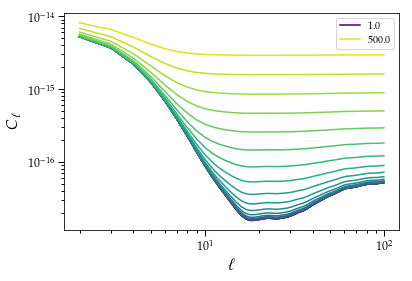

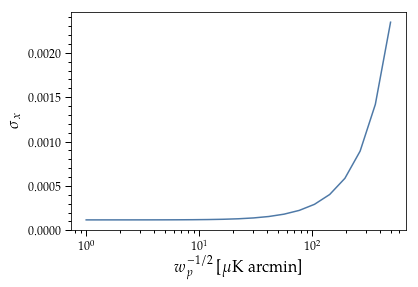

In [53]:
# It's in F_zz,l.
sigma_x = np.sqrt(1/sum(F_xxl[2:]))
sigma_xl = np.sqrt(1/F_xxl)
print(sigma_x, 1/sum(sigma_xl[2:]**2)**0.5)

wp = 50 # uK-arcmin
N_l = (wp*np.pi/180/60)**2/((2.7e6)**2)
C_l =  get_EE_2D(7, 0.1)[2:]

plt.figure()
sigma_xs = []
wps = np.logspace(0, 2+np.log10(5), 21)
wps[-1] = 500
for i, wp in enumerate(wps):
    N_l = (wp*np.pi/180/60)**2/((2.7e6)**2)
    if (i == 0) | (i == len(wps)-1):
        plt.figure(1)
        plt.plot(ell[2:], sigma_zl[2:]*(1+N_l/C_l), label=wp, color=plt.cm.viridis(i/len(wps)))
        plt.figure(2)
        plt.plot(ell[2:], C_l+N_l, label=wp, color=plt.cm.viridis(i/len(wps)))
    else:
        plt.figure(1)
        plt.plot(ell[2:], sigma_zl[2:]*(1+N_l/C_l), color=plt.cm.viridis(i/len(wps)))
        plt.figure(2)
        plt.plot(ell[2:], C_l+N_l, color=plt.cm.viridis(i/len(wps)))
    sigma_xs.append( sum(1/(sigma_xl[2:]**2*(1+N_l/C_l))**2)**-0.5  )
plt.figure(1)
plt.legend(loc='best')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\sigma_{x,\ell}$')
plt.savefig('sigmax_ell.png', bbox_inches='tight', dpi=300)

plt.figure(2)
plt.legend(loc='best')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')


# Right, it's the "as a function of noise" thing.
plt.figure()
plt.plot(wps, sigma_xs)
plt.xscale('log')
plt.xlabel(r'$w_p^{-1/2}$ [$\mathrm{\mu K\ arcmin}$]')
plt.ylabel(r'$\sigma_x$')
plt.minorticks_on()
plt.savefig('sigmax.png', bbox_inches='tight', dpi=300)

[[   23.37335284   577.22678571]
 [  577.22678571 22977.77266229]] [[11568.87815161   413.7333043 ]
 [  413.7333043     14.79618377]]
[[   4.59829402  101.17945891]
 [ 101.17945891 2464.07468917]] [[11568.87815161   413.7333043 ]
 [  413.7333043     14.79618377]]
[[  0.87997358  15.00442845]
 [ 15.00442845 280.76770719]] [[11568.87815161   413.7333043 ]
 [  413.7333043     14.79618377]]


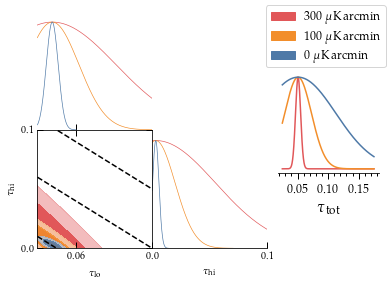

In [54]:
zre = 7
xe = 0.01

wps = np.array([cv_noise, class_noise, planck_noise])
wps = np.array([0, 100, 300])

F = []

TransMat = np.array([[1/dtaulodz**2, 1/dtaulodz/dtauhidx],
                     [1/dtaulodz/dtauhidx, 1/dtauhidx**2]])

for wp in wps:
    F.append(get_F(zre, xe, N_l=(wp*np.pi/180/60)**2/((2.7e6)**2)))

gausses = []
mean = np.array([zre, xe])
taulo, tauhi, tautot = get_taus_simp(zre, xe)
mean = np.array([taulo, tauhi])
tauvars = []
for i in range(len(F)):
    print(F[i], TransMat)
    cov = np.linalg.inv(F[i]*TransMat)
    gauss = GaussianND(mean, cov, labels=[r'$\tau_\mathrm{lo}$', r'$\tau_\mathrm{hi}$'], 
                                          label=r'${0}\ \mathrm{{\mu K\,arcmin}}$'.format(wps[i]))
    gausses.append(gauss)
    tauvars.append(sum(np.diag(cov)))



g = plots.getSubplotPlotter()
g.triangle_plot(gausses[::-1], filled=True, colors=['C2', 'C1', 'C0'], contour_colors=['C2','C1','C0'])

fig = plt.gcf()
for ax in fig.axes[:2]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
fig.axes[0].set_xlim(0.04, 0.1)
fig.axes[2].set_xlim(0.04, 0.1)

fig.axes[1].set_xlim(0, 0.1)
fig.axes[2].set_ylim(0, 0.1)
taulos = np.linspace(0.04, 0.1)
fig.axes[2].plot(taulos, 0.1-taulos, 'k--')
fig.axes[2].plot(taulos, 0.05-taulos, 'k--')
fig.axes[2].plot(taulos, 0.15-taulos, 'k--')

ax = fig.add_axes([1, 0.4, 0.35, 0.35])
tau_arr = np.linspace(0.025, 0.175, 1000)
for i in range(len(F)):
    G = np.exp(-(tautot-tau_arr)**2/(2*tauvars[i]))
    ax.plot(tau_arr, G, color='C{0}'.format(2-i))
ax.set_xlabel(r'$\tau_\mathrm{tot}$')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.minorticks_on()

plt.savefig('heinrich_2.png', dpi=200, bbox_inches='tight')

0.0019230645804572245
0.004335667891402855
0.009911047536282422


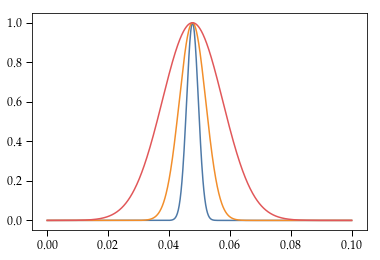

In [55]:
# Ignore xe?
tarr = np.linspace(0, 0.1, 1000)
for i in range(len(F)):
    cov = 1/((F[i]*TransMat)[0,0])
    print(cov**0.5)
    plt.plot(tarr, np.exp(-(taulo-tarr)**2/(2*cov)))


In [56]:
# use the values in the d\ln L/d\theta as a function of d\theta...
# Worth looking at the C_ls, the finite differences, asking what happens at 2e-6.


# Imagine a beam that's gonna kick up as ell increases with the beam scale...

# It would be nice to show C_ell and N_ell on the same axes, but you are starting to lose the info.


# Let's do an outline next, see what we coudl do ehre, is there something missing, etc.?

In [57]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://journals.aps.org/prd/article/10.1103/PhysRevD.98.063514/figures/12/medium")
# Want to make a version of this plot from Heinrich et al.

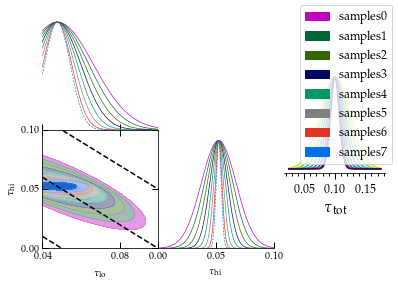

In [58]:
zre = 7
xe = 0.2
wps = np.arange(0, 320, 40)

colors = plt.cm.viridis(wps/300)

F = []

TransMat = np.array([[1/dtaulodz**2, 1/dtaulodz/dtauhidx],
                     [1/dtaulodz/dtauhidx, 1/dtauhidx**2]])

for wp in wps:
    F.append(get_F(zre, xe, N_l=(wp*np.pi/180/60)**2/((2.7e6)**2)))

gausses = []
mean = np.array([zre, xe])
taulo, tauhi, tautot = get_taus_simp(zre, xe)
mean = np.array([taulo, tauhi])
tauvars = []
taulovars = []
tauhivars = []

for i in range(len(F)):
    cov = np.linalg.inv(F[i]*TransMat)
    gauss = GaussianND(mean, cov, labels=[r'$\tau_\mathrm{lo}$', r'$\tau_\mathrm{hi}$'])
    gausses.append(gauss)
    tauvars.append(sum(np.diag(cov)))
    taulovars.append(cov[0,0])
    tauhivars.append(cov[1,1])



g = plots.getSubplotPlotter()
#print(colors, type(colors))
colors = tuple(colors)
#g.triangle_plot(gausses[::-1], filled=True, colors=colors, contour_colors=colors)
g.triangle_plot(gausses[::-1], filled=True)

fig = plt.gcf()
for ax in fig.axes[:2]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
fig.axes[0].set_xlim(0.04, 0.1)
fig.axes[2].set_xlim(0.04, 0.1)

fig.axes[1].set_xlim(0, 0.1)
fig.axes[2].set_ylim(0, 0.1)
taulos = np.linspace(0.04, 0.1)
fig.axes[2].plot(taulos, 0.1-taulos, 'k--')
fig.axes[2].plot(taulos, 0.05-taulos, 'k--')
fig.axes[2].plot(taulos, 0.15-taulos, 'k--')

ax = fig.add_axes([1, 0.4, 0.35, 0.35])
tau_arr = np.linspace(0.025, 0.175, 1000)
for i in range(len(F))[::-1]:
    G = np.exp(-(tautot-tau_arr)**2/(2*tauvars[i]))
    ax.plot(tau_arr, G, color=colors[i])
ax.set_xlabel(r'$\tau_\mathrm{tot}$')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.minorticks_on()


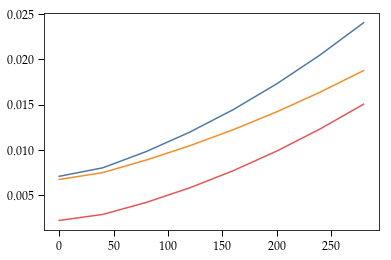

In [59]:
plt.plot(wps, np.array(tauvars)**0.5)
plt.plot(wps, np.array(taulovars)**0.5)
plt.plot(wps, np.array(tauhivars)**0.5)

#g.triangle_plot(gausses[::-1])

In [60]:
# Would be good to have the chi2 per multipole stuff.

# Still no discussion of the beam response

# The number of modes is lost...

# Could be interesting to talk about scales from a systematics/foregrounds point of view.

# Maybe mention in the conclusions sections that foregrounds are athing with a certain amplitude.


# What sort of forecasting did Wayne Hu's group do?

# Maybe see how the steepness changes things?


# Let's do the TE stuff as well. Since Planck doesn't use the low-ell TE likelihood.

# Make a similar plot of the TE.


# What about the case of single reionization event, more extendced? The joint fit of delta z and z_reio?

# Figure 18 of Planck XLVII, what does this changing hyperbolic stuff do to the l = 10-20 range?
# Make some C_l^EE plots.

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


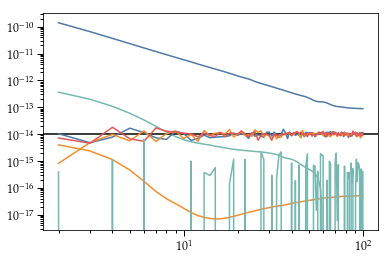

In [61]:
ell, EE, TE, TT = get_spectra(7, 0, lmax=100, spectra=True, all_spectra=True)

plt.loglog(ell[2:], TT[2:])
plt.loglog(ell[2:], EE[2:])
plt.loglog(ell[2:], TE[2:],color='C3')

N_l = 1e-14*np.ones(hp.nside2npix(128))
plt.axhline(N_l[0], color='k')
nT = hp.synfast(N_l, nside=128)
nQ = hp.synfast(N_l, nside=128)
nU = hp.synfast(N_l, nside=128)
n = np.array([nT, nQ, nU])
Nlhat = hp.anafast(n, lmax=100)
plt.loglog(ell[2:], Nlhat[0][2:], color='C0')
plt.loglog(ell[2:], Nlhat[1][2:], color='C1')
plt.loglog(ell[2:], Nlhat[2][2:], color='C2')
plt.loglog(ell[2:], Nlhat[3][2:], color='C3')

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


(1e-18, 1e-09)

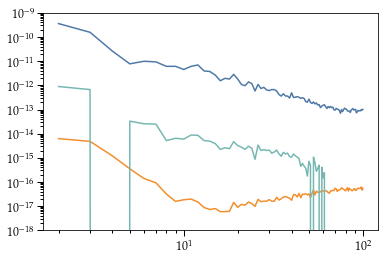

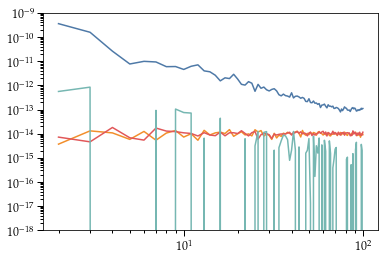

In [62]:
M_raw = hp.synfast([TT, EE, 0*TE, TE], nside=128, new = True)
M_noisy = M_raw + n

Clhat0 = hp.anafast(M_raw, lmax=100)
Clhat1 = hp.anafast(M_noisy, lmax=100)

plt.figure()
for i in range(4):
    plt.loglog(ell[2:], Clhat0[i][2:])
plt.ylim([1e-18, 1e-9])
plt.figure()
for i in range(4):
    plt.loglog(ell[2:], Clhat1[i][2:])
plt.ylim([1e-18, 1e-9])


In [63]:
def get_F_allspec(zre, xe, dzre=5e-3, dxre=1e-5, ell_arr=False, lmin=2, lmax=100, N_lT=0, N_lE=0):
    Fs = []
    ell, EE, TE, TT = get_spectra(zre, x_e, lmax=lmax, spectra=True, all_spectra=True)
    ell, dEEz, dTEz, dTTz = get_spectra(zre+dzre, x_e, lmax=lmax, spectra=True, all_spectra=True)
    ell, dEEx, dTEx, dTTx = get_spectra(zre, x_e+dxre, lmax=lmax, spectra=True, all_spectra=True)
    dTTdx = (dTTx-TT)/dxre
    dEEdx = (dEEx-EE)/dxre
    dTEdx = (dTEx-TE)/dxre
    dTTdz = (dTTz-TT)/dzre
    dEEdz = (dEEz-EE)/dzre
    dTEdz = (dTEz-TE)/dzre
    for l in ell[lmin:lmax+1]:
        F = np.zeros((2,2))
        Cl = np.array([[TT[l] + N_lT, TE[l]],[TE[l],EE[l] + N_lE]])
        dCldx = np.array([[dTTdx[l], dTEdx[l]], [dTEdx[l], dEEdx[l]]])
        dCldz = np.array([[dTTdz[l], dTEdz[l]], [dTEdz[l], dEEdz[l]]])
        Clinv = np.linalg.inv(Cl)
        xx = np.trace(Clinv.dot(dCldx.dot(Clinv.dot(dCldx))))*(2*l+1)/2
        xz = np.trace(Clinv.dot(dCldx.dot(Clinv.dot(dCldz))))*(2*l+1)/2
        zz = np.trace(Clinv.dot(dCldz.dot(Clinv.dot(dCldz))))*(2*l+1)/2
        F[0,0] += zz
        F[1,0] += xz
        F[0,1] += xz
        F[1,1] += xx
        Fs.append(F)
    return Fs

def get_F_fixT(zre, xe, dzre=5e-3, dxre=1e-5, ell_arr=False, lmin=2, lmax=100, N_lT=0, N_lE=0):
    Fs = []
    ell, EE, TE, TT = get_spectra(zre, x_e, lmax=lmax, spectra=True, all_spectra=True)
    ell, dEEz, dTEz, dTTz = get_spectra(zre+dzre, x_e, lmax=lmax, spectra=True, all_spectra=True)
    ell, dEEx, dTEx, dTTx = get_spectra(zre, x_e+dxre, lmax=lmax, spectra=True, all_spectra=True)
    dTTdx = (dTTx-TT)/dxre*0
    dEEdx = (dEEx-EE)/dxre
    dTEdx = (dTEx-TE)/dxre
    dTTdz = (dTTz-TT)/dzre*0
    dEEdz = (dEEz-EE)/dzre
    dTEdz = (dTEz-TE)/dzre
    for l in ell[lmin:lmax+1]:
        F = np.zeros((2,2))
        Cl = np.array([[TT[l] + N_lT, TE[l]],[TE[l],EE[l] + N_lE]])
        dCldx = np.array([[dTTdx[l], dTEdx[l]], [dTEdx[l], dEEdx[l]]])
        dCldz = np.array([[dTTdz[l], dTEdz[l]], [dTEdz[l], dEEdz[l]]])
        Clinv = np.linalg.inv(Cl)
        xx = np.trace(Clinv.dot(dCldx.dot(Clinv.dot(dCldx))))*(2*l+1)/2
        xz = np.trace(Clinv.dot(dCldx.dot(Clinv.dot(dCldz))))*(2*l+1)/2
        zz = np.trace(Clinv.dot(dCldz.dot(Clinv.dot(dCldz))))*(2*l+1)/2
        F[0,0] += zz
        F[1,0] += xz
        F[0,1] += xz
        F[1,1] += xx
        Fs.append(F)
    return Fs


def get_F_onespec(zre, xe, dzre=5e-3, dxre=1e-5, ell_arr=False, lmin=2, lmax=100, N_lT=0, N_lE=0):
    Fs = []
    ell, EE, TE, TT = get_spectra(zre, x_e, lmax=lmax, spectra=True, all_spectra=True)
    ell, dEEz, dTEz, dTTz = get_spectra(zre+dzre, x_e, lmax=lmax, spectra=True, all_spectra=True)
    ell, dEEx, dTEx, dTTx = get_spectra(zre, x_e+dxre, lmax=lmax, spectra=True, all_spectra=True)
    dTTdx = (dTTx-TT)/dxre
    dEEdx = (dEEx-EE)/dxre
    dTEdx = (dTEx-TE)/dxre
    dTTdz = (dTTz-TT)/dzre
    dEEdz = (dEEz-EE)/dzre
    dTEdz = (dTEz-TE)/dzre
    for l in ell[lmin:lmax+1]:
        F = np.zeros((2,2))
        Cl = EE[l] + N_lE
        dCldx = dEEdx[l]
        dCldz = dEEdz[l]
        Clinv = 1/Cl
        xx = Clinv*dCldx*Clinv*dCldx*(2*l+1)/2
        xz = Clinv*dCldx*Clinv*dCldz*(2*l+1)/2
        zz = Clinv*dCldz*Clinv*dCldz*(2*l+1)/2
        F[0,0] += zz
        F[1,0] += xz
        F[0,1] += xz
        F[1,1] += xx
        Fs.append(F)
    return Fs

Fwish = get_F_allspec(7, 0.0)
Fwish = np.array(Fwish)
FEE = np.array(get_F_onespec(7, 0.0))
Ftest = np.array(get_F_fixT(7, 0.0))

In [64]:
CovWish = np.linalg.inv(np.sum(Fwish,axis=0))
CovEE = np.linalg.inv(np.sum(FEE,axis=0))
CovTest = np.linalg.inv(np.sum(Ftest, axis=0))
print(CovWish[0,0]**0.5, CovWish[1,1]**0.5)
print(CovEE[0,0]**0.5, CovEE[1,1]**0.5)
print(CovTest[0,0]**0.5, CovTest[1,1]**0.5)

0.34073728462614505 0.004593762888058643
0.4893806238855725 0.006305335926413053
0.3426574841797599 0.0045992236795362705


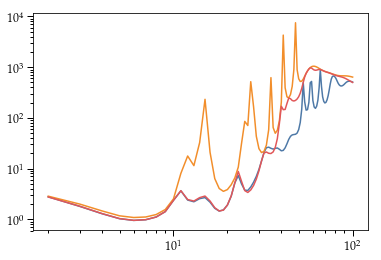

In [65]:
plt.loglog(ell[2:], Fwish[:,0,0]**-0.5)
plt.loglog(ell[2:], FEE[:,0,0]**-0.5)
plt.loglog(ell[2:], Ftest[:,0,0]**-0.5)

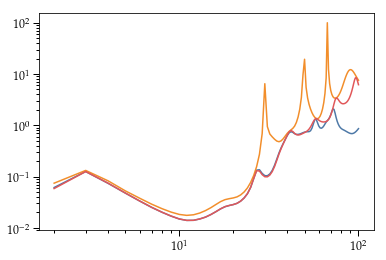

In [66]:
plt.loglog(ell[2:], Fwish[:,1,1]**-0.5)
plt.loglog(ell[2:], FEE[:,1,1]**-0.5)
plt.loglog(ell[2:], Ftest[:,1,1]**-0.5)

[0.34003341 0.34190346 0.45617098] [0.00458427 0.0045891  0.00587745] 0.0
[1.35319201 1.36050262 1.42537927] [0.04470154 0.04474855 0.05526187] 1e-15


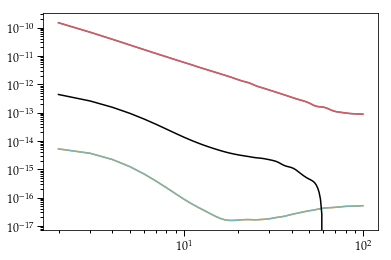

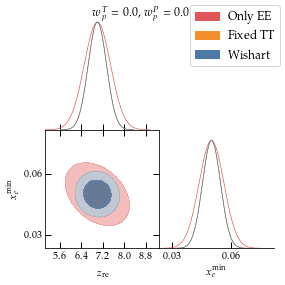

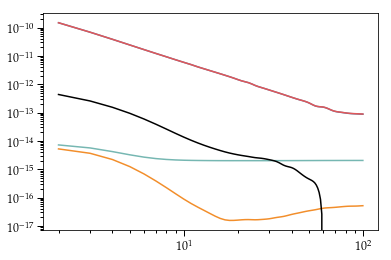

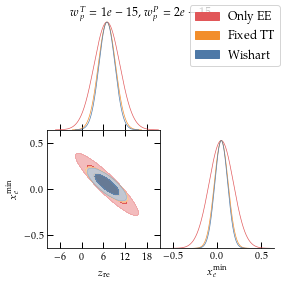

In [67]:
zre = 7
xe = 0.05

N_lTs = [0, 50, 100, 200, 500]
N_lEs = [0, 100, 200, 400, 1000]

N_lTs = [0, 50, 1000]
N_lEs = [0, 100, 1000]


wps = np.array([cv_noise, class_noise, planck_noise])
wps = np.array([0, 100, 300])

F = []

TransMat = np.array([[1/dtaulodz**2, 1/dtaulodz/dtauhidx],
                     [1/dtaulodz/dtauhidx, 1/dtauhidx**2]])

ell, EE, TE, TT = get_spectra(zre, x_e, lmax=lmax, spectra=True, all_spectra=True)

N_lTs = np.array([0, 1e-15])
N_lEs = N_lTs*2
for i in range(len(N_lTs)):
    N_lT = N_lTs[i]
    N_lE = N_lEs[i]
    F = []
    F.append(np.sum(get_F_allspec(zre, xe, N_lT=N_lT, N_lE = N_lE), axis=0))
    F.append(np.sum(get_F_fixT(zre, xe, N_lT=N_lT, N_lE=N_lE), axis=0))
    F.append(np.sum(get_F_onespec(zre, xe, N_lT=N_lT, N_lE=N_lE), axis=0))
    plt.figure()
    plt.loglog(ell[2:], TT[2:])
    plt.loglog(ell[2:], EE[2:])
    plt.loglog(ell[2:], TT[2:] + N_lT)
    plt.loglog(ell[2:], EE[2:] + N_lE)
    plt.loglog(ell[2:], TE[2:], color='k')

    F = np.array(F)
    print(F[:,0,0]**-0.5, F[:,1,1]**-0.5, N_lT)
    labels=['Wishart', 'Fixed TT', 'Only EE']
         
    gausses = []
    mean = np.array([zre, xe])
    tauvars = []
    for i in range(len(F)):
        cov = np.linalg.inv(F[i])
        gauss = GaussianND(mean, cov, labels=[r'$z_\mathrm{re}$', r'$x_e^\mathrm{min}$'], 
                                              label=labels[i])
        gausses.append(gauss)
        tauvars.append(sum(np.diag(cov)))



    g = plots.getSubplotPlotter()
    g.triangle_plot(gausses[::-1], filled=True, colors=['C2', 'C1', 'C0'], contour_colors=['C2','C1','C0'])

    fig = plt.gcf()
    for ax in fig.axes[:2]:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
    plt.suptitle(r'$w_p^T={0}, w_p^P={1}$'.format(N_lT, N_lE))

[<getdist.gaussian_mixtures.GaussianND object at 0x7f0ca40f0e10>, <getdist.gaussian_mixtures.GaussianND object at 0x7f0ca40f0278>, <getdist.gaussian_mixtures.GaussianND object at 0x7f0ca40f0ba8>, <getdist.gaussian_mixtures.GaussianND object at 0x7f0ca40f0c88>]


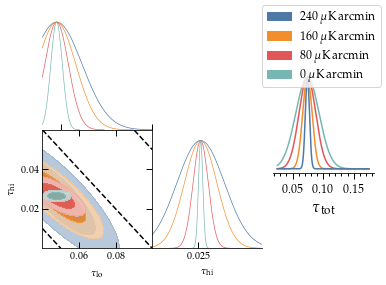

In [68]:
zre = 7
xe = 0.1
wps = np.arange(0, 320, 80)

colors = plt.cm.viridis(wps/300)

F = []

TransMat = np.array([[1/dtaulodz**2, 1/dtaulodz/dtauhidx],
                     [1/dtaulodz/dtauhidx, 1/dtauhidx**2]])

for wp in wps:
    F.append(np.sum(get_F_allspec(zre, xe, N_lT=(wp*np.pi/180/60)**2/((2.7e6)**2), N_lE=(wp*np.pi/180/60)**2/((2.7e6)**2)),axis=0))

gausses = []
mean = np.array([zre, xe])
taulo, tauhi, tautot = get_taus_simp(zre, xe)
mean = np.array([taulo, tauhi])
tauvars = []
taulovars = []
tauhivars = []

for i in range(len(F)):
    cov = np.linalg.inv(F[i]*TransMat)
    gauss = GaussianND(mean, cov, labels=[r'$\tau_\mathrm{lo}$', r'$\tau_\mathrm{hi}$'], 
                      label=r'${0}\,\mathrm{{\mu K\,arcmin}}$'.format(wps[i]))
    gausses.append(gauss)
    tauvars.append(sum(np.diag(cov)))
    taulovars.append(cov[0,0])
    tauhivars.append(cov[1,1])

print(gausses)

g = plots.getSubplotPlotter()
#print(colors, type(colors))
#colors = tuple(colors)
colors = [r'C{0}'.format(i) for i in range(len(F))]
g.triangle_plot(gausses[::-1], filled=True, colors=colors, contour_colors=colors)
#g.triangle_plot(gausses[::-1], filled=True)

fig = plt.gcf()
for ax in fig.axes[:2]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
fig.axes[0].set_xlim(0.04, 0.1)
fig.axes[2].set_xlim(0.04, 0.1)

fig.axes[1].set_xlim(0, 0.06)
fig.axes[2].set_ylim(0, 0.06)

fig.axes[2].set_yticks([0.02, 0.04])
fig.axes[2].set_xticks([0.06, 0.08])


taulos = np.linspace(0.04, 0.1)
fig.axes[2].plot(taulos, 0.1-taulos, 'k--')
fig.axes[2].plot(taulos, 0.05-taulos, 'k--')
fig.axes[2].plot(taulos, 0.15-taulos, 'k--')

ax = fig.add_axes([1, 0.4, 0.35, 0.35])
tau_arr = np.linspace(0.025, 0.175, 1000)
for i in range(len(F))[::-1]:
    G = np.exp(-(tautot-tau_arr)**2/(2*tauvars[i]))
    ax.plot(tau_arr, G, color=colors[i])
ax.set_xlabel(r'$\tau_\mathrm{tot}$')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.minorticks_on()
plt.savefig('fisher_wishart.pdf', bbox_inches='tight')

[<getdist.gaussian_mixtures.GaussianND object at 0x7f0c29b34f98>, <getdist.gaussian_mixtures.GaussianND object at 0x7f0c29b34be0>, <getdist.gaussian_mixtures.GaussianND object at 0x7f0c29b34c18>, <getdist.gaussian_mixtures.GaussianND object at 0x7f0c29ae8b00>]


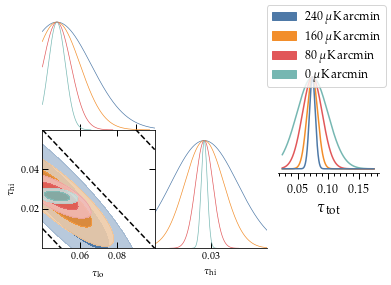

In [69]:
zre = 7
xe = 0.1
wps = np.arange(0, 320, 80)

colors = plt.cm.viridis(wps/300)

F = []

TransMat = np.array([[1/dtaulodz**2, 1/dtaulodz/dtauhidx],
                     [1/dtaulodz/dtauhidx, 1/dtauhidx**2]])

for wp in wps:
    F.append(np.sum(get_F_onespec(zre, xe, N_lT=(wp*np.pi/180/60)**2/((2.7e6)**2), N_lE=(wp*np.pi/180/60)**2/((2.7e6)**2)),axis=0))

gausses = []
mean = np.array([zre, xe])
taulo, tauhi, tautot = get_taus_simp(zre, xe)
mean = np.array([taulo, tauhi])
tauvars = []
taulovars = []
tauhivars = []

for i in range(len(F)):
    cov = np.linalg.inv(F[i]*TransMat)
    gauss = GaussianND(mean, cov, labels=[r'$\tau_\mathrm{lo}$', r'$\tau_\mathrm{hi}$'], 
                      label=r'${0}\,\mathrm{{\mu K\,arcmin}}$'.format(wps[i]))
    gausses.append(gauss)
    tauvars.append(sum(np.diag(cov)))
    taulovars.append(cov[0,0])
    tauhivars.append(cov[1,1])

print(gausses)

g = plots.getSubplotPlotter()
#print(colors, type(colors))
#colors = tuple(colors)
colors = [r'C{0}'.format(i) for i in range(len(F))]
g.triangle_plot(gausses[::-1], filled=True, colors=colors, contour_colors=colors)
#g.triangle_plot(gausses[::-1], filled=True)

fig = plt.gcf()
for ax in fig.axes[:2]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
fig.axes[0].set_xlim(0.04, 0.1)
fig.axes[2].set_xlim(0.04, 0.1)

fig.axes[2].set_yticks([0.02, 0.04])
fig.axes[2].set_xticks([0.06, 0.08])

fig.axes[1].set_xlim(0, 0.06)
fig.axes[2].set_ylim(0, 0.06)
taulos = np.linspace(0.04, 0.1)
fig.axes[2].plot(taulos, 0.1-taulos, 'k--')
fig.axes[2].plot(taulos, 0.05-taulos, 'k--')
fig.axes[2].plot(taulos, 0.15-taulos, 'k--')

ax = fig.add_axes([1, 0.4, 0.35, 0.35])
tau_arr = np.linspace(0.025, 0.175, 1000)
for i in range(len(F))[::-1]:
    G = np.exp(-(tautot-tau_arr)**2/(2*tauvars[i]))
    ax.plot(tau_arr, G, color=colors[i])
ax.set_xlabel(r'$\tau_\mathrm{tot}$')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.minorticks_on()
plt.savefig('fisher_chi2.pdf', bbox_inches='tight')

In [70]:
'''
def lnprob_wish_ell(zre, x_e, Clhat, N_lT=0, N_lE=0):
    # This returns log(P)
    TThat, EEhat, BBhat, TEhat, TBhat, EBhat = Clhat
    ell, ee, te, tt = get_spectra(zre, x_e,  spectra=True, lmax=len(EEhat)-1, all_spectra=True)

    tt += N_lT
    ee += N_lE
    n = 2
    Cl = np.array([[tt, te], [te, ee]])
    Clhat = np.array([[TThat, TEhat],[TEhat, EEhat]])
    x = Clhat.dot(np.linalg.inv(Cl))
    chi2_ell = (2*ell+1)*(Clhat/Cl + np.log(Cl/Clhat)-n)
    return -chi2_ell/2
'''

'\ndef lnprob_wish_ell(zre, x_e, Clhat, N_lT=0, N_lE=0):\n    # This returns log(P)\n    TThat, EEhat, BBhat, TEhat, TBhat, EBhat = Clhat\n    ell, ee, te, tt = get_spectra(zre, x_e,  spectra=True, lmax=len(EEhat)-1, all_spectra=True)\n\n    tt += N_lT\n    ee += N_lE\n    n = 2\n    Cl = np.array([[tt, te], [te, ee]])\n    Clhat = np.array([[TThat, TEhat],[TEhat, EEhat]])\n    x = Clhat.dot(np.linalg.inv(Cl))\n    chi2_ell = (2*ell+1)*(Clhat/Cl + np.log(Cl/Clhat)-n)\n    return -chi2_ell/2\n'

266.35783621802614
301.51313203450644 24.7525059920736


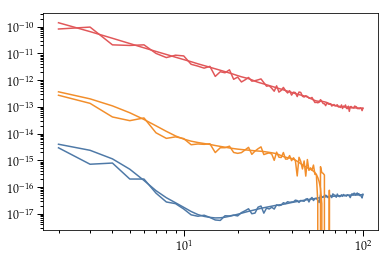

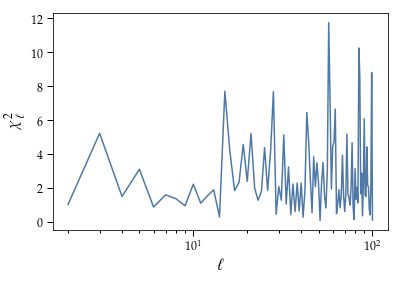

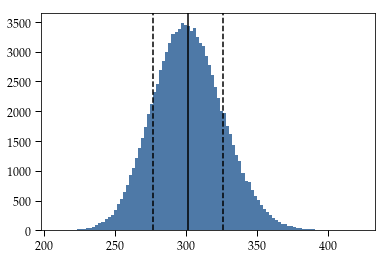

In [71]:
import healpy as hp
zre, x_e = 7, 0.00
lmax = 100
ell, ee, te, tt = get_spectra(zre, x_e,  spectra=True, lmax=lmax, all_spectra=True)
Cls = np.array([tt, ee, 0*ee, te])
ls = np.arange(2,lmax+1)

n = 2





Cl = np.array([[tt, te], [te, ee]])
Cl = np.swapaxes(Cl, 1,2)
Cl = np.swapaxes(Cl, 0,1)
bla2 = np.linalg.inv(Cl[2:])

chi2s = []

for i in range(100000):
    Clhats = hp.alm2cl(hp.synalm(Cls, new=True, lmax=lmax))
    Clhat = np.array([[Clhats[0], Clhats[3]], [Clhats[3], Clhats[1]]])
    Clhat = np.swapaxes(Clhat, 1,2)
    Clhat = np.swapaxes(Clhat, 0,1)
    bla = Clhat[2:]
    
    x = np.einsum('ijk,ikl->ijl',bla, bla2)
    chi2_ell = (2*ls+1)*(np.trace(x, axis1=1, axis2=2) - np.linalg.slogdet(x)[1] - n)
    chi2 = sum(chi2_ell)
    chi2s.append(chi2)

plt.loglog(ell[2:], ee[2:], color='C0')
plt.loglog(ell[2:], Clhats[1][2:], color='C0')
plt.loglog(ell[2:], te[2:], color='C1')
plt.loglog(ell[2:], Clhats[3][2:], color='C1')
plt.loglog(ell[2:], tt[2:], color='C2')
plt.loglog(ell[2:], Clhats[0][2:], color='C2')


plt.figure()
plt.semilogx(ls, chi2_ell)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\chi^2_\ell$')

from scipy.special import digamma, polygamma
print(sum(chi2_ell))
chi2_ell_est = (2*ls+1)*(n*np.log(ls+0.5)-sum([digamma(ls+1-i/2) for i in range(1, n+1)]))
chi2_ell_var = (2*ls+1)*( (2*ls+1)*sum([polygamma(1, ls+1-i/2) for i in range(1, n+1)]) - 2*n)
print(sum(chi2_ell_est), sum(chi2_ell_var)**0.5)


plt.figure()
plt.hist(chi2s, 100)
plt.axvline(sum(chi2_ell_est), color='k')
plt.axvline(sum(chi2_ell_est)+sum(chi2_ell_var)**0.5, color='k', linestyle='--')
plt.axvline(sum(chi2_ell_est)-sum(chi2_ell_var)**0.5, color='k', linestyle='--')

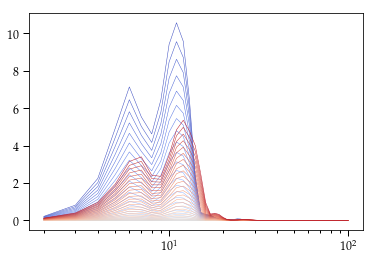

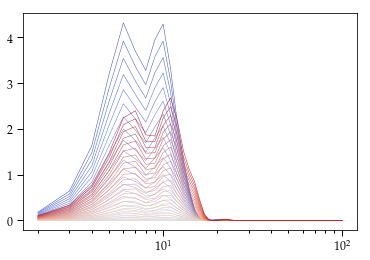

In [72]:
zres = np.linspace(6, 8, 50)
chi2s_ell_all = []
chi2s_ell_EE = []

Clhats = Cls
ell, ee, te, tt = get_spectra(zre, x_e,  spectra=True, lmax=lmax, all_spectra=True)
Cl = np.array([[tt, te], [te, ee]])
Cl = np.swapaxes(Cl, 1,2)
Cl = np.swapaxes(Cl, 0,1)
bla = Cl[2:]

for i in range(len(zres)):
    ell, ee, te, tt = get_spectra(zres[i], 0,  spectra=True, lmax=lmax, all_spectra=True)
    Cl = np.array([[tt, te], [te, ee]])
    Cl = np.swapaxes(Cl, 1,2)
    Cl = np.swapaxes(Cl, 0,1)
    bla2 = np.linalg.inv(Cl[2:])
    x = np.einsum('ijk,ikl->ijl',bla, bla2)
    chi2_ell = (2*ls+1)*(np.trace(x, axis1=1, axis2=2) - np.linalg.slogdet(x)[1] - n)
    plt.figure(1)
    plt.semilogx(ls, chi2_ell, color=plt.cm.coolwarm(i/len(zres)), lw=0.5)
    chi2s_ell_all.append(sum(chi2_ell))
    x = Clhats[1][2:]/ee[2:]
    chi2_ell = (2*ls+1)*(x - np.log(x) - 1)
    plt.figure(2)
    plt.semilogx(ls, chi2_ell, color=plt.cm.coolwarm(i/len(zres)), lw=0.5)
    chi2s_ell_EE.append(sum(chi2_ell))
    

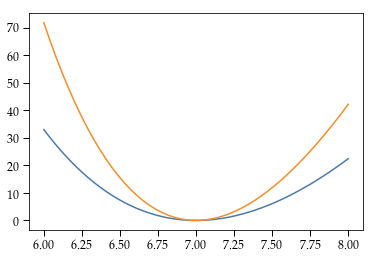

In [73]:
chi2_ell_est = (2*ls+1)*(1*np.log(ls+0.5)-sum([digamma(ls+1-i/2) for i in range(1, 1+1)]))
plt.plot(zres, np.array(chi2s_ell_EE))
#plt.axhline(sum(chi2_ell_est))

chi2_ell_est = (2*ls+1)*(2*np.log(ls+0.5)-sum([digamma(ls+1-i/2) for i in range(1, 2+1)]))
plt.plot(zres, np.array(chi2s_ell_all))
#plt.axhline(sum(chi2_ell_est), color='C1')


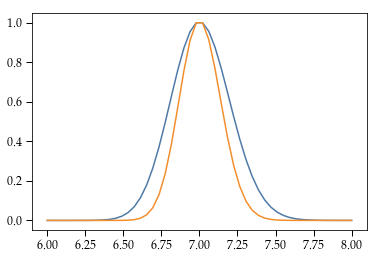

In [74]:
chi2s_ell_EE = np.array(chi2s_ell_EE)
chi2s_ell_all = np.array(chi2s_ell_all)
plt.plot(zres, np.exp(-(chi2s_ell_EE-chi2s_ell_EE.min())/2))
plt.plot(zres, np.exp(-(chi2s_ell_all-chi2s_ell_all.min())/2))

CosmoComputationError: 

Error in Class: perturb_init(L:289) :error in perturb_timesampling_for_sources(ppr, pba, pth, ppt);
=>perturb_timesampling_for_sources(L:1242) :could not allocate ppt->sources[index_md][index_ic*ppt->tp_size[index_md]+index_type] with size 2514776

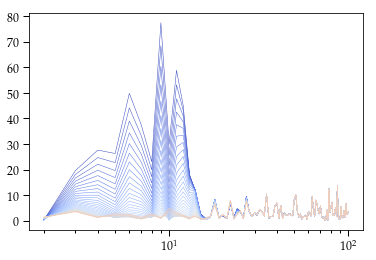

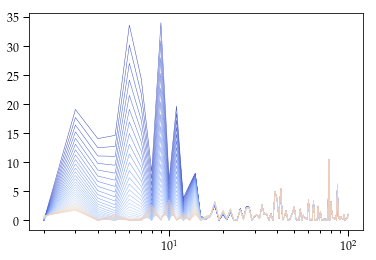

In [75]:
zres = np.linspace(5, 9, 50)
chi2s_ell_all = []
chi2s_ell_EE = []

Clhats = hp.alm2cl(hp.synalm(Cls, new=True, lmax=lmax))
Clhat = np.array([[Clhats[0], Clhats[3]], [Clhats[3], Clhats[1]]])
Clhat = np.swapaxes(Clhat, 1,2)
Clhat = np.swapaxes(Clhat, 0,1)
bla = Clhat[2:]

for i in range(len(zres)):
    ell, ee, te, tt = get_spectra(zres[i], 0,  spectra=True, lmax=lmax, all_spectra=True)
    Cl = np.array([[tt, te], [te, ee]])
    Cl = np.swapaxes(Cl, 1,2)
    Cl = np.swapaxes(Cl, 0,1)
    bla2 = np.linalg.inv(Cl[2:])
    x = np.einsum('ijk,ikl->ijl',bla, bla2)
    chi2_ell = (2*ls+1)*(np.trace(x, axis1=1, axis2=2) - np.linalg.slogdet(x)[1] - n)
    plt.figure(1)
    plt.semilogx(ls, chi2_ell, color=plt.cm.coolwarm(i/len(zres)), lw=0.5)
    chi2s_ell_all.append(sum(chi2_ell))
    x = Clhats[1][2:]/ee[2:]
    chi2_ell = (2*ls+1)*(x - np.log(x) - 1)
    plt.figure(2)
    plt.semilogx(ls, chi2_ell, color=plt.cm.coolwarm(i/len(zres)), lw=0.5)
    chi2s_ell_EE.append(sum(chi2_ell))
    

In [ ]:
chi2_ell_est = (2*ls+1)*(1*np.log(ls+0.5)-sum([digamma(ls+1-i/2) for i in range(1, 1+1)]))
plt.plot(zres, np.array(chi2s_ell_EE))
plt.axhline(sum(chi2_ell_est))
n = 2
chi2_ell_var = (2*ls+1)*( (2*ls+1)*sum([polygamma(1, ls+1-i/2) for i in range(1, n+1)]) - 2*n)
chi2_var = sum(chi2_ell_var)
plt.fill_between(zres, sum(chi2_ell_est) - chi2_var**0.5, sum(chi2_ell_est) + chi2_var**0.5, color='C0', alpha=0.1)

chi2_ell_est = (2*ls+1)*(2*np.log(ls+0.5)-sum([digamma(ls+1-i/2) for i in range(1, 2+1)]))
plt.plot(zres, np.array(chi2s_ell_all))
plt.axhline(sum(chi2_ell_est), color='C1')
n = 1
chi2_ell_var = (2*ls+1)*( (2*ls+1)*sum([polygamma(1, ls+1-i/2) for i in range(1, n+1)]) - 2*n)
plt.fill_between(zres, sum(chi2_ell_est) - chi2_var**0.5, sum(chi2_ell_est) + chi2_var**0.5, color='C1', alpha=0.1)

plt.xlim([4.8, 9.2])
plt.ylim([0, 600])

In [ ]:
chi2s_ell_EE = np.array(chi2s_ell_EE)
chi2s_ell_all = np.array(chi2s_ell_all)
plt.plot(zres, np.exp(-(chi2s_ell_EE-chi2s_ell_EE.min())/2))
plt.plot(zres, np.exp(-(chi2s_ell_all-chi2s_ell_all.min())/2))

In [ ]:
# Could see what happens when we crank

# What is the number that we get from the Fisher compared with HFI now...

# There's apparently an effort to reduce the Planck error on tau to the blue book levels...

# What were the Planck forecasts originally from...? Maybe I could replace with certain interesting numbers.
# Numbers that correspond 



# Janet comment on reading intro... there's a section in the Planck 2018 cosmological parameters paper that's not
# included here; they seem to be saying they can only find evidence for late-time reionization. Could use that
# also as one of the conflicting things. It's the Millea and the 2016/2018. 
# She points out it's odd to not cite a Planck collaboration paper.

In [ ]:
def dertest(zre=8, x_e=0.05, dzre=5e-5, dxre=1e-5, lmin=2, lmax=100):
    for i in range(4):
        ell, EE, TE, TT = get_spectra(zre, x_e, lmax=lmax, spectra=True, all_spectra=True)
        ell, dEdx, dTEdx, dTdx = get_spectra(zre, x_e+dxre, lmax=lmax, spectra=True, all_spectra=True)
        ell, dEdz, dTEdz, dTdz = get_spectra(zre+dzre, x_e, lmax=lmax, spectra=True, all_spectra=True)
        dEEdz = (dEdz - EE)/dzre
        dTEdz = (dTEdz - TE)/dzre
        dTTdz = (dTdz - TT)/dzre
        plt.subplot(311)
        plt.semilogy(ell[2:], abs(dTTdz[2:]))
        plt.subplot(312)
        plt.semilogy(ell[2:], abs(dTEdz[2:]))
        plt.subplot(313)
        plt.semilogy(ell[2:], abs(dEEdz[2:]))


In [ ]:
dertest()